<h1>Диагностика болезней</h1>

Датасет: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database <br>

В рамках данного проекта выполнен анализ и моделирование данных на основе датасета Pima Indians Diabetes, доступного на Kaggle. Цель проекта — построить эффективную модель для предсказания наличия диабета у пациентов на основе различных медицинских показателей.

В проекте:

- Проведен анализ и визуализация исходных данных для выявления особенностей и взаимосвязей между переменными  
- Выполнена генерация новых информативных признаков для повышения качества будущих моделей  
- Реализованы и сравнены современные алгоритмы машинного обучения для задачи классификации  
- Подобраны и оптимизированы параметры лучшей модели для достижения высокой точности


<h1>Загрузка данных и нужные импорты</h1>

In [305]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import warnings

In [4]:
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('diabetes.csv')

<h1>Анализ данных</h1>

Функция feature_analysis поможет лучше исследовать признак. Мы выведем основные статистические метрики, которые будут давать дополнительное понимание:

1. Минимальное, максимальное, среднее, медиана - для понимания самых часто встречаемых значений, центральных значений, центральных значений в упорядоченном наборе.
2. Стандартное отклонение нам нужно, чтобы понимать разброс данных относительно среднего
3. Ассиметрия: указывает на ассиметрию распределения. Интерпретируем так: 1. Положительная: длинный хвост справа; 2. Отрицательная: длинный хвост слева. Будет полезна для понимания отклонения распределения от нормального.
4. Эксцесс: 1. >0, более острое распределение; 2. <0 - более "плоское", полезен для понимания пиковой формы.

In [8]:
def feature_analysis(data, feature):
    print('Признак', feature)
    print('#=#=#=#=#=#=#=#=#=#')
    print(f'Минимальное значение: {min(data[feature])}')
    print('#=#=#=#=#=#=#=#=#=#')
    print(f'Среднее значение: {np.mean(data[feature])}')
    print('#=#=#=#=#=#=#=#=#=#')
    print(f'Максимальное значение: {max(data[feature])}')
    print('#=#=#=#=#=#=#=#=#=#')
    print(f'Медиана: {np.median(data[feature])}')
    print('#=#=#=#=#=#=#=#=#=#')
    print(f'Ассиметрия: {stats.skew(data[feature])}')
    print('#=#=#=#=#=#=#=#=#=#')
    print(f'Дисперсия: {np.var(data[feature])}')
    print('#=#=#=#=#=#=#=#=#=#')
    print(f'Эксцесс: {stats.kurtosis(data[feature])}')
    print('#=#=#=#=#=#=#=#=#=#')

In [9]:
def anomaly(data, feature):
    # Эта функция будет выводить аномальные значения (Слишком большие или слишком маленькие)
    # Далее будем думать, возможны ли они, сколько их и могут ли они быть реальными медицинскими показателями
    q1 = np.quantile(data[feature], 0.25)
    q3 = np.quantile(data[feature], 0.75)
    IQR = q3 - q1
    lower = q1 - 1.5 * IQR
    upper = q3 + 1.5 * IQR
    print(f'Аномальные значения: {data[(data[feature] > upper) | (data[feature] < lower)][feature].count()}')
    print(data[(data[feature] > upper) | (data[feature] < lower)][feature])
    return data[(data[feature] > upper) | (data[feature] < lower)][feature]

In [10]:
def fog(data, feature, target='Outcome'):
    target_0 = data[data[target] == 0][feature]
    target_1 = data[data[target] == 1][feature]
    sns.set_theme(style='whitegrid')

    plt.figure(figsize=(10,6))
    sns.histplot(target_0, kde=True, color='#9467bd', alpha=0.6, bins=30, label=f'{target} = 0')
    sns.histplot(target_1, kde=True, color='#ff7f0e', alpha=0.6, bins=30, label=f'{target} = 1')

    plt.title(f'Распределение {feature} по {target}', fontsize=16, fontweight='bold')
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.show()

In [13]:
def scatter_visual(data, x, y):
    sns.set(style='whitegrid')
    fig, axs = plt.subplots(figsize=(10,6))
    fig.suptitle('Влияние мед. показателей на диабет', fontsize=18)
    axs.set_title(f'Зависимость {x} от {y}', fontsize=14)
    palette = sns.color_palette(['#FF8C00', '#8A2BE2'])
    sns.scatterplot(data=data, x=x, y=y, ax=axs, color=palette[1])
    axs.grid(True, linestyle='--', alpha=0.65)
    axs.set_xlabel(x)
    axs.set_ylabel(y)
    plt.show()

In [14]:
def hist_visual(data, feature):
    sns.set(style='whitegrid')
    palette = sns.color_palette(['#FF8C00', '#8A2BE2'])
    plt.figure(figsize=(10,6))
    data[feature].hist(bins=20, color=palette[1], alpha=0.7)
    mean = data[feature].mean()
    median = data[feature].median()
    plt.axvline(mean, color='orange', linestyle='dashed', linewidth=2, label='Среднее')
    plt.axvline(median, color='yellow', linestyle='dashed', linewidth=2, label='Медиана')
    plt.title(f'Гистограмма для {feature}', fontsize=14)
    plt.legend()
    plt.xlabel(feature, fontsize=12)
    plt.ylabel("Частота", fontsize=12)
    plt.tight_layout()
    plt.show()

In [15]:
def df_boxplot(data):
    # Нужно стандартизировать данные, перед тем, как построить boxplot.
    sdf = lambda X: ((X - np.mean(X)) / np.std(X))
    df_temp = data.copy()
    df_temp = df_temp.apply(sdf)
    plt.figure(figsize=(15, 12))
    plt.boxplot(df_temp, labels=data.columns)
    plt.title('Boxplot для признаков')
    plt.grid=True
    plt.show()

In [16]:
def median_fill(data, feature):
    new = data[data[feature] != 0]
    new = new[[feature, 'Outcome']].groupby(['Outcome'])[[feature]].median().reset_index()
    return new
    

In [17]:
def scatter_with_outcome(data, feature_x, feature_y, target='Outcome'):
    plt.figure(figsize=(10, 6))
    
    colors = data[target].map({0: 'purple', 1: 'orange'})
    
    plt.scatter(data[feature_x], data[feature_y], c=colors, alpha=0.5)
    
    plt.title(f'Диаграмма рассеивания: {feature_x} & {feature_y}')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    
    plt.show()

In [18]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [20]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

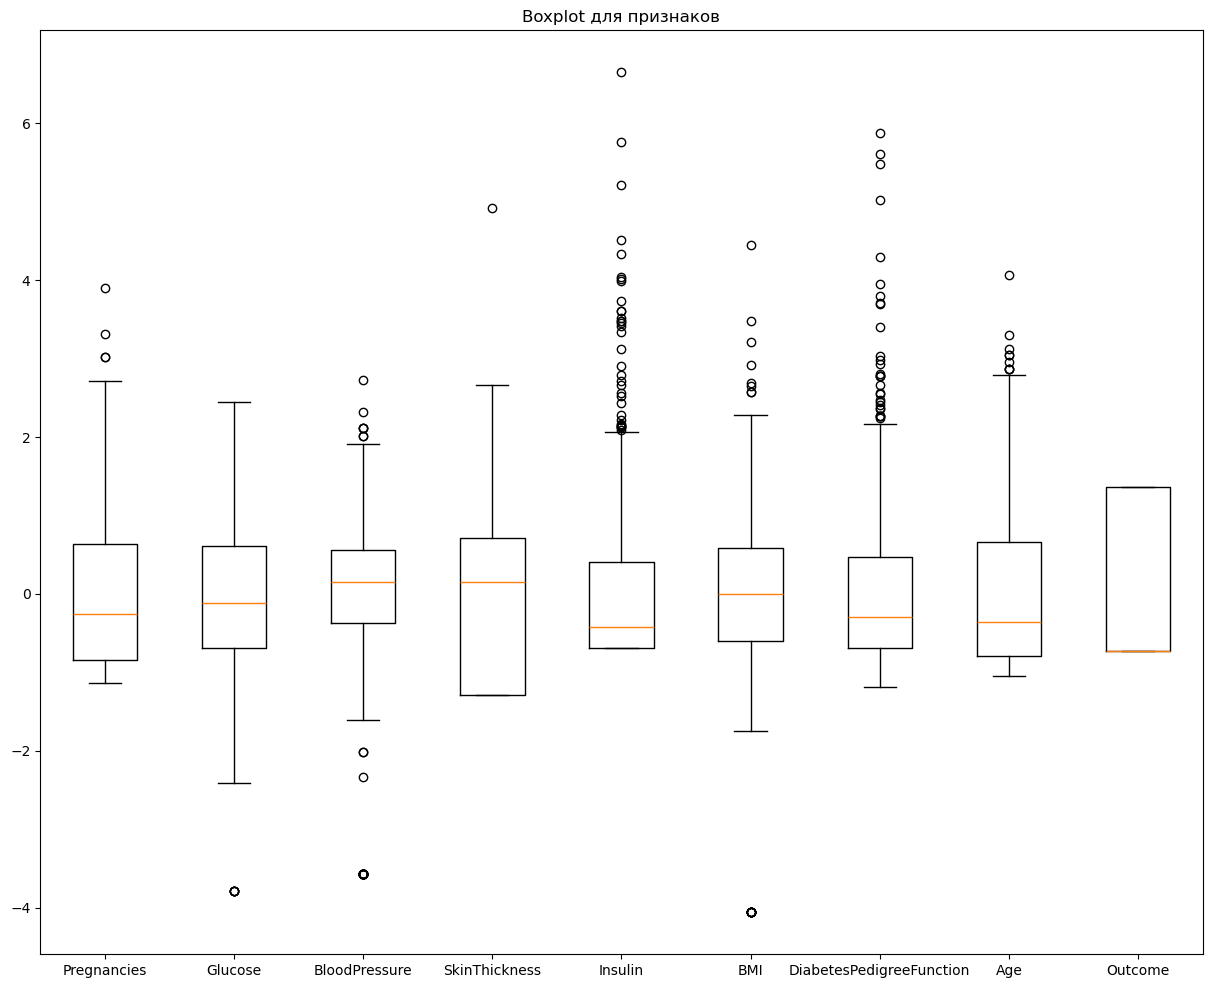

In [21]:
df_boxplot(df)

<h3>Что изображено на Boxplot?</h3>

1. Высокий IQR наблюдается у следующих признаков: Pregnancies, SkinThickness, BMI, Age, Glucose.
2. Ассиметрия распределения: 1) Age - правосторонняя ассиметрия; 2) DiabetesPedigreeFunction - правосторонняя ассиметрия; 3) Pregnancies - правостороняя ассиметрия; 4) SkinThickness - правосторонняя ассиметрия; 5) Insulin - правосторонняя ассиметрия. Все перечисленные признаки имеют в своем распределении значительную ассиметрию, но признаки: 1) BMI имеет менее значительную правостороннюю ассиметрию; 2) Glucose, BloodPressure - имеют либо совсем незначительную ассиметрию, либо не имеют ее совсем.
3. Выбросы: 1) Insulin; 2) Pregnancies; 3) Glucose; 4) BloodPressure; 5) Age; 6) DiabetesPedigreeFunction; 7) BMI.

In [23]:
feature_analysis(df, 'Pregnancies')

Признак Pregnancies
#=#=#=#=#=#=#=#=#=#
Минимальное значение: 0
#=#=#=#=#=#=#=#=#=#
Среднее значение: 3.8450520833333335
#=#=#=#=#=#=#=#=#=#
Максимальное значение: 17
#=#=#=#=#=#=#=#=#=#
Медиана: 3.0
#=#=#=#=#=#=#=#=#=#
Ассиметрия: 0.8999119408414357
#=#=#=#=#=#=#=#=#=#
Дисперсия: 11.33927239312061
#=#=#=#=#=#=#=#=#=#
Эксцесс: 0.15038273760948462
#=#=#=#=#=#=#=#=#=#


In [24]:
anomaly(df, 'Pregnancies')

Аномальные значения: 4
88     15
159    17
298    14
455    14
Name: Pregnancies, dtype: int64


88     15
159    17
298    14
455    14
Name: Pregnancies, dtype: int64

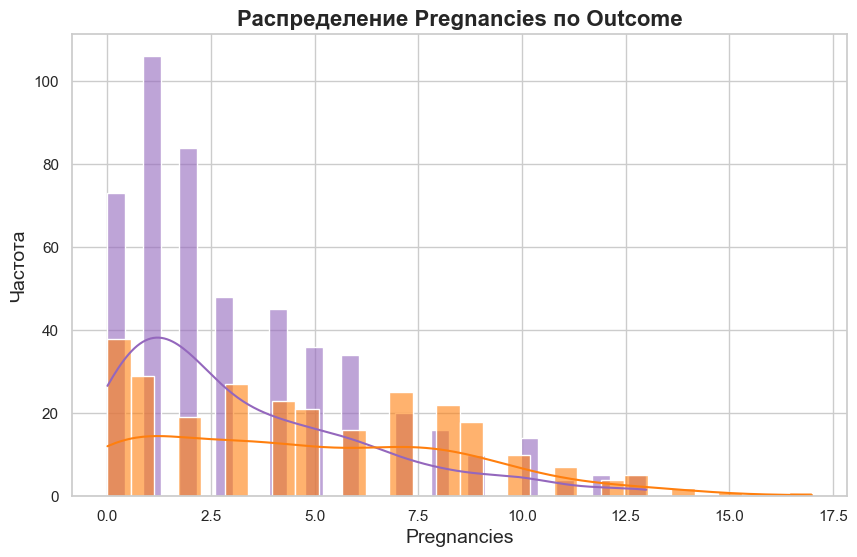

In [25]:
fog(df, 'Pregnancies')

Как таковой закономерности увидеть не получается. Единственная приметная деталь - после показаетля 12.5 отсутствуют значения Outcome=0. То есть, большое количество беременностей влияет на возникновение диабета.

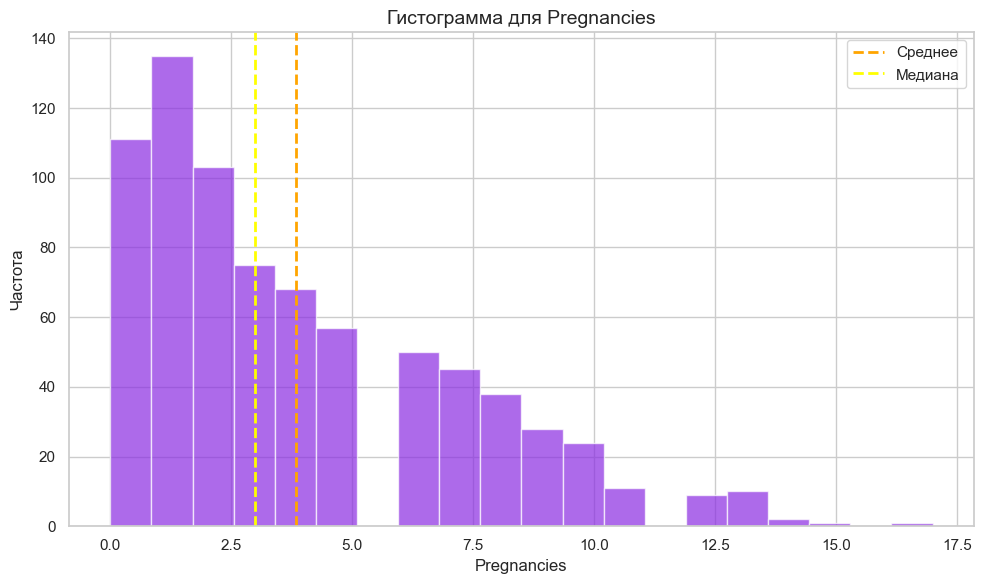

In [27]:
hist_visual(df, 'Pregnancies')

Большинство значений сосредоточены в промежутке от 0 до 5. Среднее больше медианы, что говорит об положительной ассиметрии. Больших значений гораздо меньше.

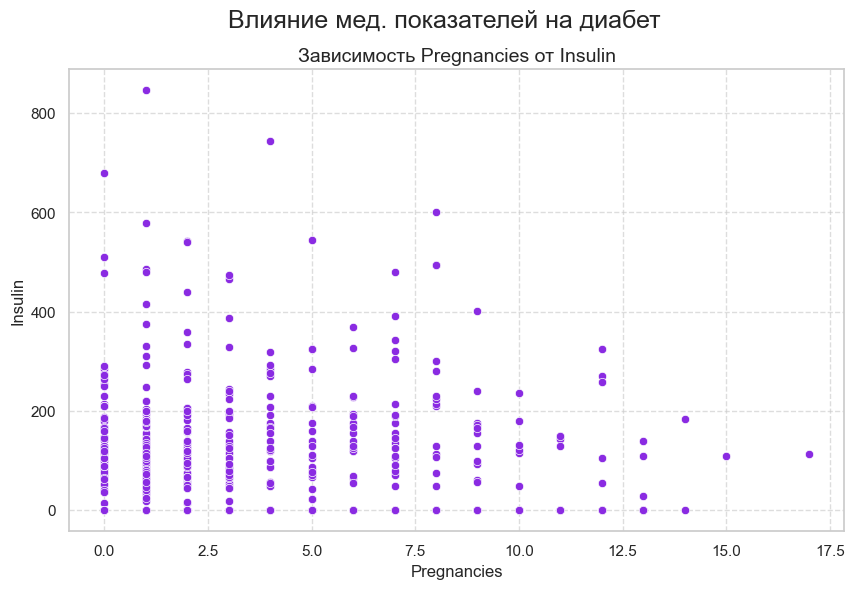

In [29]:
scatter_visual(df, 'Pregnancies', 'Insulin')

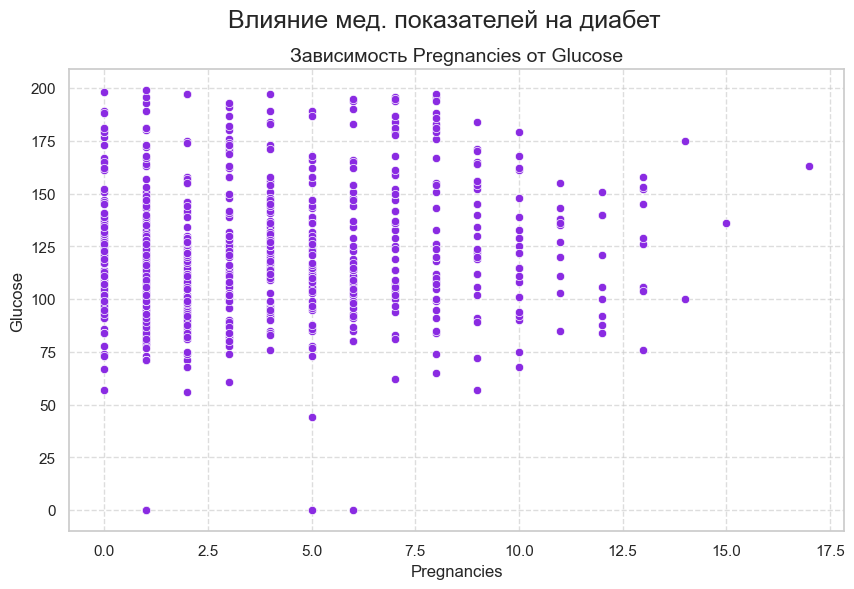

In [30]:
scatter_visual(df, 'Pregnancies', 'Glucose')

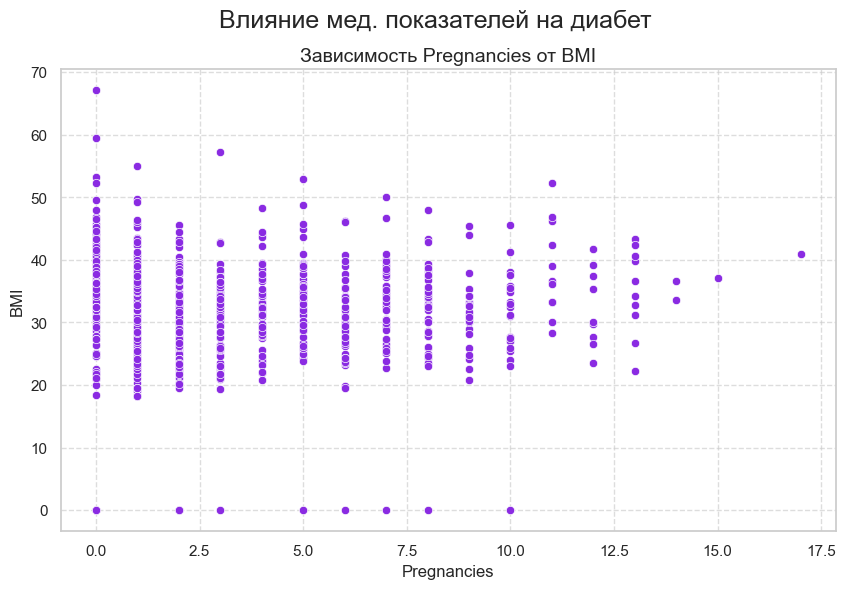

In [31]:
scatter_visual(df, 'Pregnancies', 'BMI')

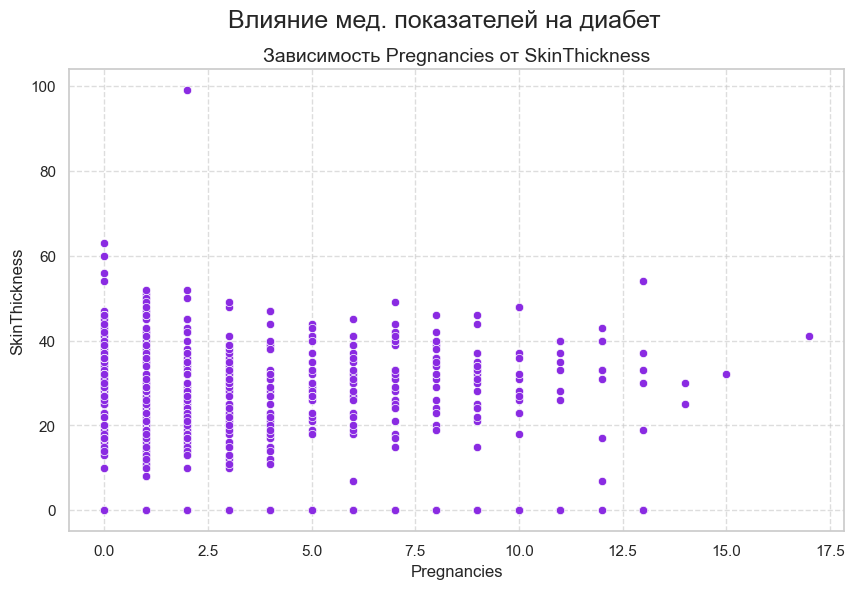

In [32]:
scatter_visual(df, 'Pregnancies', 'SkinThickness')

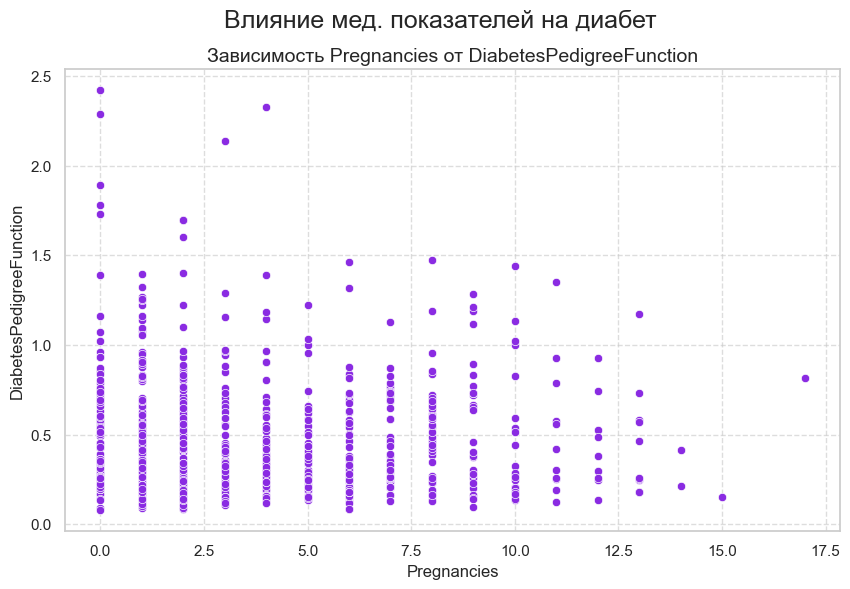

In [33]:
scatter_visual(df, 'Pregnancies', 'DiabetesPedigreeFunction')

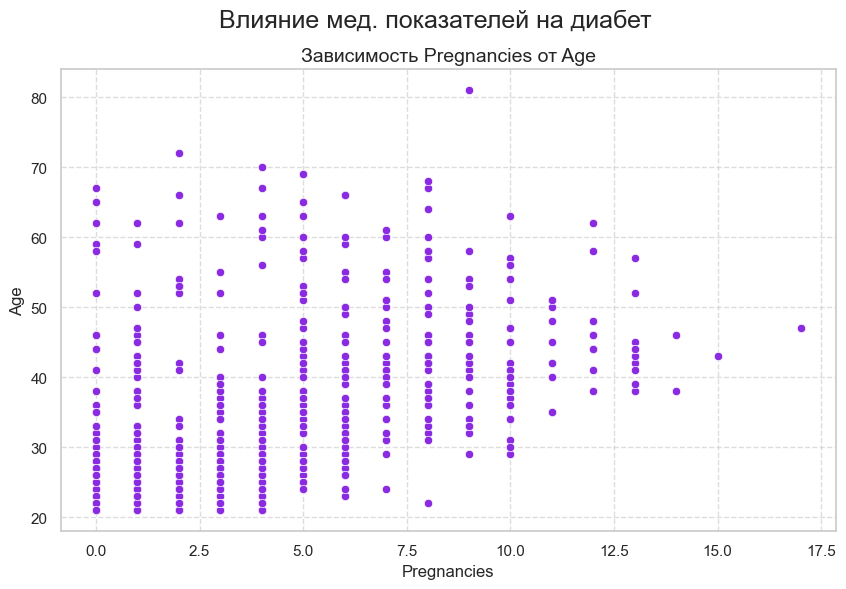

In [34]:
scatter_visual(df, 'Pregnancies', 'Age')

Построив диаграммы рассеивания для Pregnancies и остальных признаков никаких закономерностей увидеть не получается. Это может свидетельствовать о том, что Pregnancies (или другие признаки) никак не коррелируют друг с другом. Более точно сможем увидеть это на карте корреляций. <br>
Аномальных значений всего 4. Позже посмотрим, какое влияние они будут оказывать на целевую переменную.

In [36]:
feature_analysis(df, 'Glucose')

Признак Glucose
#=#=#=#=#=#=#=#=#=#
Минимальное значение: 0
#=#=#=#=#=#=#=#=#=#
Среднее значение: 120.89453125
#=#=#=#=#=#=#=#=#=#
Максимальное значение: 199
#=#=#=#=#=#=#=#=#=#
Медиана: 117.0
#=#=#=#=#=#=#=#=#=#
Ассиметрия: 0.17341395519987735
#=#=#=#=#=#=#=#=#=#
Дисперсия: 1020.9172617594401
#=#=#=#=#=#=#=#=#=#
Эксцесс: 0.6288133337300685
#=#=#=#=#=#=#=#=#=#


In [37]:
df[df['Glucose'] == 0]

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
75             1        0             48             20        0  24.7   
182            1        0             74             20       23  27.7   
342            1        0             68             35        0  32.0   
349            5        0             80             32        0  41.0   
502            6        0             68             41        0  39.0   

     DiabetesPedigreeFunction  Age  Outcome  
75                      0.140   22        0  
182                     0.299   21        0  
342                     0.389   22        0  
349                     0.346   37        1  
502                     0.727   41        1

Вопросы вызывают 5 значений, где Glucose = 0, может ли такое быть на самом деле? В интернете на это есть ответ - в теории значение может быть близким к нулю, но нулем не являтся. И нормальным состоянием это не называют, близкая к нулю глюкоза требует срочного медицинского вмешательства. Что делать с такими значениями? - посмотрим позже. Возможно, заменим нулевые значения средним.

In [39]:
anomaly(df, 'Glucose')

Аномальные значения: 5
75     0
182    0
342    0
349    0
502    0
Name: Glucose, dtype: int64


75     0
182    0
342    0
349    0
502    0
Name: Glucose, dtype: int64

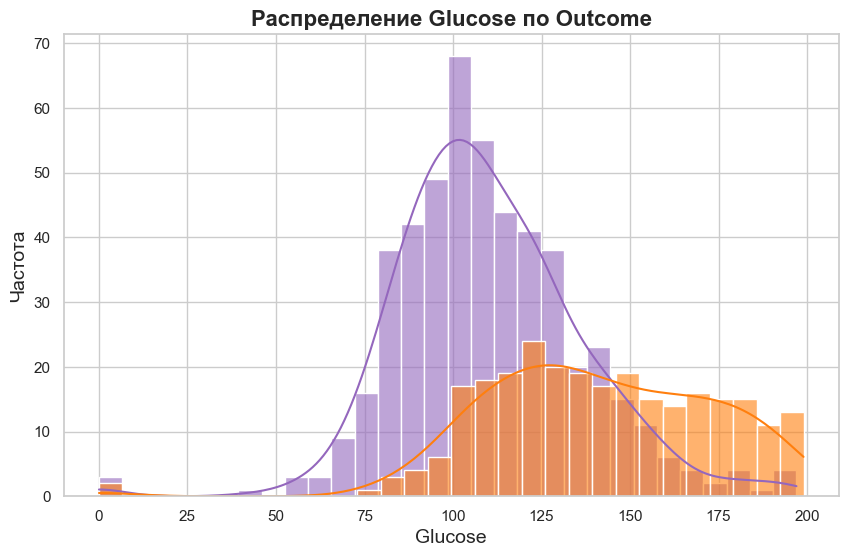

In [40]:
fog(df, 'Glucose')

Интересная деталь: если избавиться от нулевых значений, то низкая глюкоза практически не встречается у больных диабетом людей, а высокая наоборот - редко встречается у здоровых людей. График больных сильно скошен вправо, в сторону высоких показателей. Позже проверим эту гипотезу.

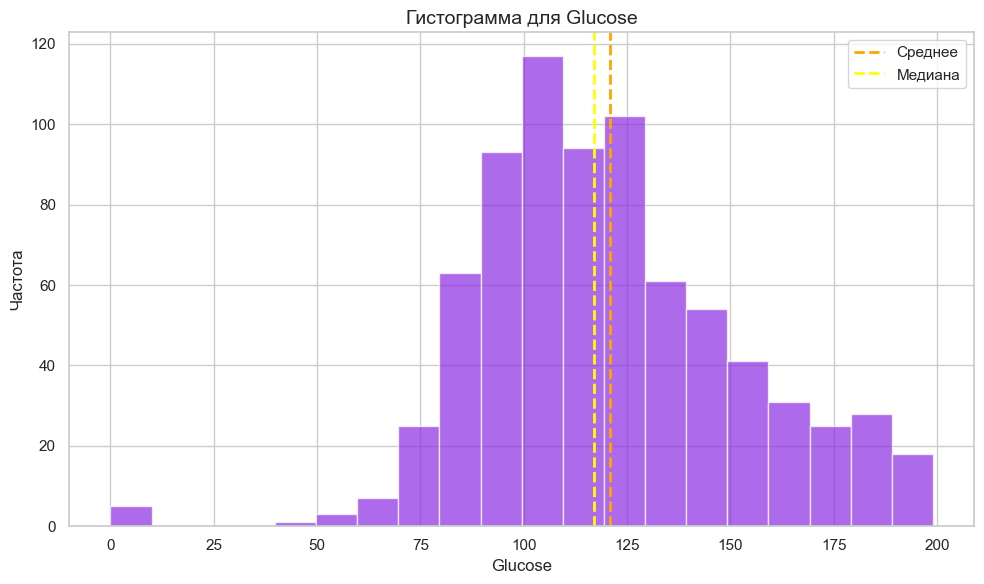

In [42]:
hist_visual(df, 'Glucose')

График смещен вправо. Среднее больше медианы. Объектов с очень низкой глюкозой мало, основное количество записей сосредоточено в диапазоне от +- 85 до +- 140.

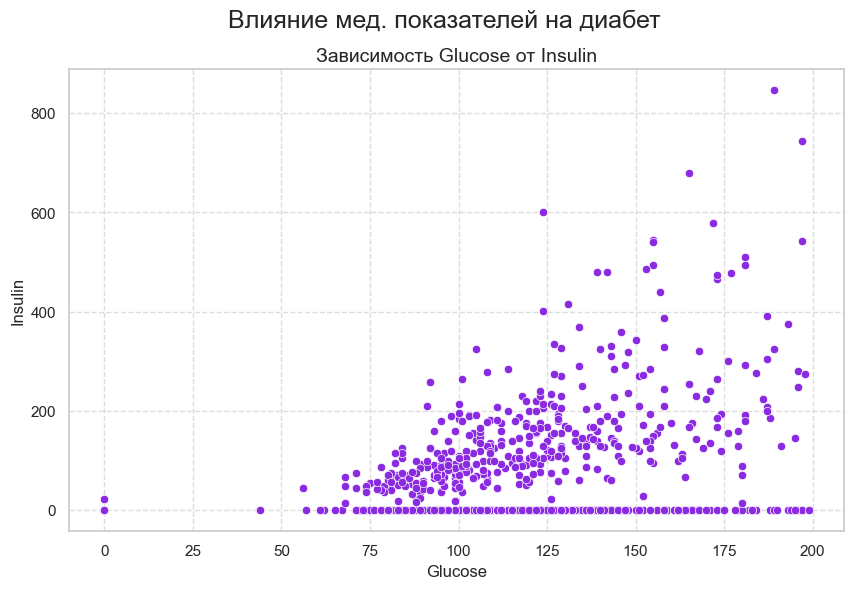

In [44]:
scatter_visual(df, 'Glucose', 'Insulin')

Можно предположить, что взаимосвязь у признаков имеется. Чем больше показатель Glucose, тем больше Insulin. Позже изучим эту деталь на карте корреляций.

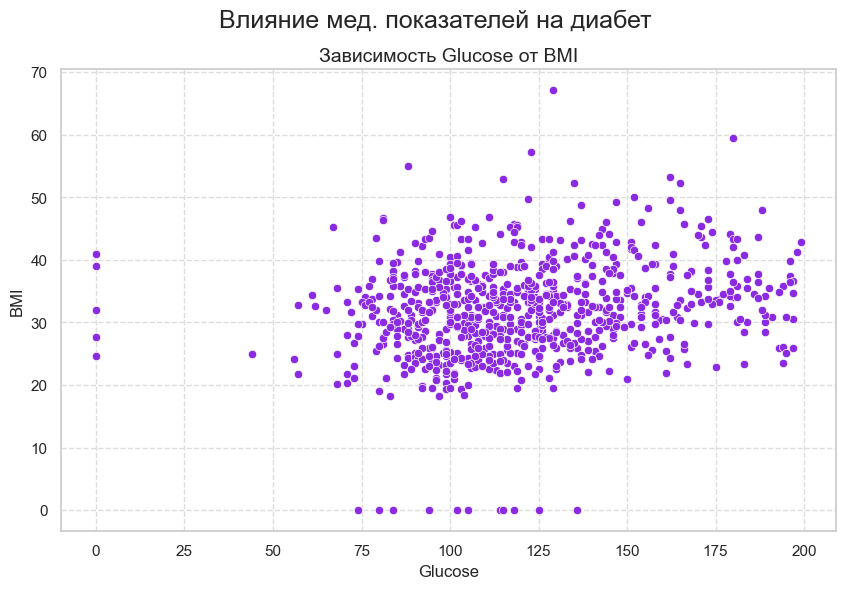

In [46]:
scatter_visual(df, 'Glucose', 'BMI')

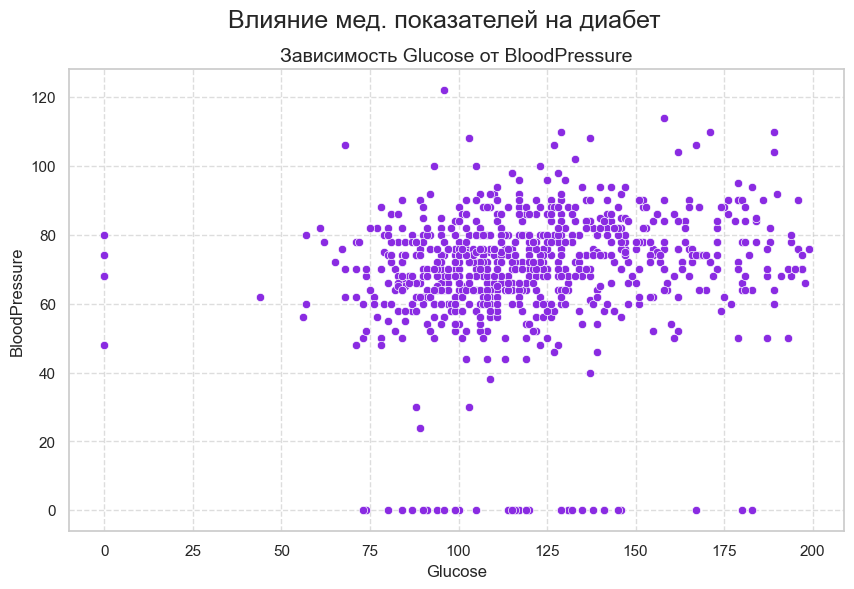

In [47]:
scatter_visual(df, 'Glucose', 'BloodPressure')

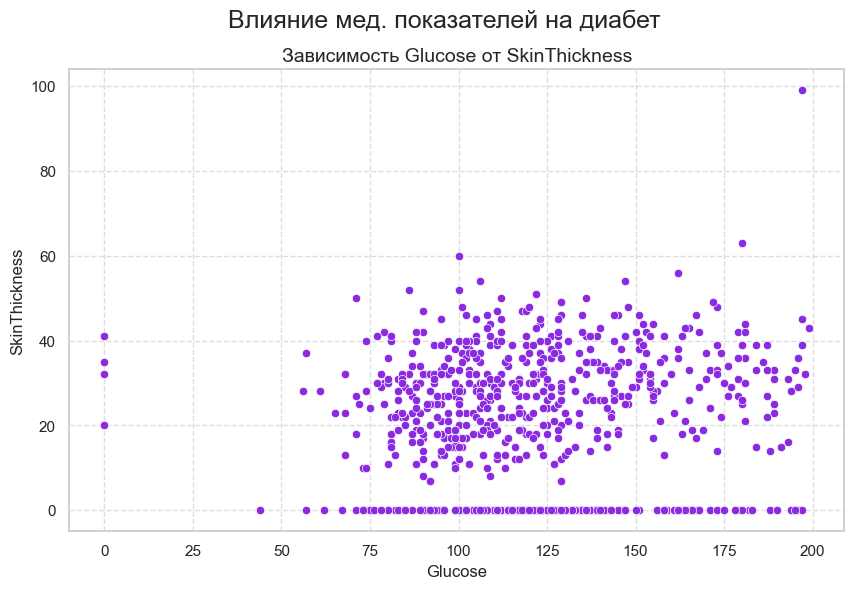

In [48]:
scatter_visual(df, 'Glucose', 'SkinThickness')

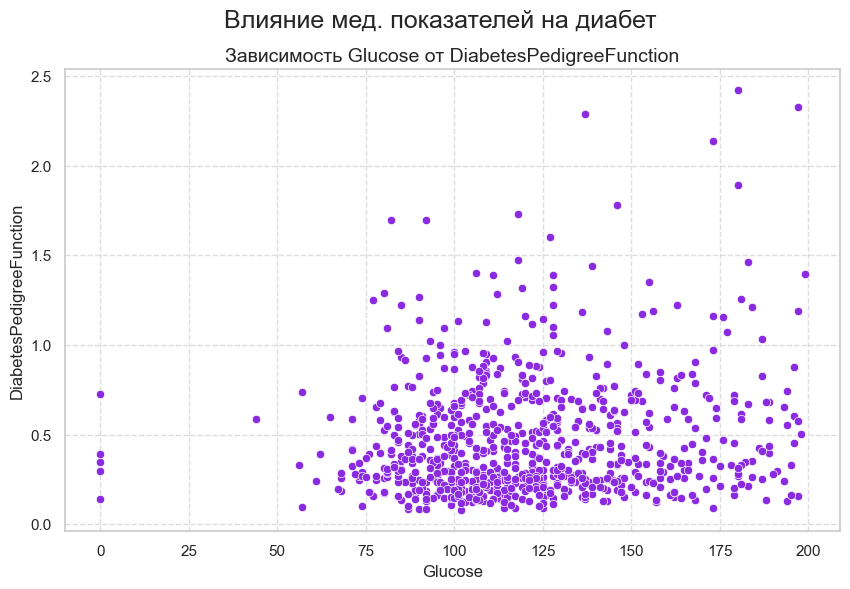

In [49]:
scatter_visual(df, 'Glucose', 'DiabetesPedigreeFunction')

In [50]:
feature_analysis(df, 'BloodPressure')

Признак BloodPressure
#=#=#=#=#=#=#=#=#=#
Минимальное значение: 0
#=#=#=#=#=#=#=#=#=#
Среднее значение: 69.10546875
#=#=#=#=#=#=#=#=#=#
Максимальное значение: 122
#=#=#=#=#=#=#=#=#=#
Медиана: 72.0
#=#=#=#=#=#=#=#=#=#
Ассиметрия: -1.8400052311728738
#=#=#=#=#=#=#=#=#=#
Дисперсия: 374.1594492594401
#=#=#=#=#=#=#=#=#=#
Эксцесс: 5.138690662525438
#=#=#=#=#=#=#=#=#=#


In [51]:
anomaly(df, 'BloodPressure')

Аномальные значения: 45
7        0
15       0
18      30
43     110
49       0
60       0
78       0
81       0
84     108
106    122
125     30
172      0
177    110
193      0
222      0
261      0
266      0
269      0
300      0
332      0
336      0
347      0
357      0
362    108
426      0
430      0
435      0
453      0
468      0
484      0
494      0
522      0
533      0
535      0
549    110
589      0
597     24
601      0
604      0
619      0
643      0
691    114
697      0
703      0
706      0
Name: BloodPressure, dtype: int64


7        0
15       0
18      30
43     110
49       0
60       0
78       0
81       0
84     108
106    122
125     30
172      0
177    110
193      0
222      0
261      0
266      0
269      0
300      0
332      0
336      0
347      0
357      0
362    108
426      0
430      0
435      0
453      0
468      0
484      0
494      0
522      0
533      0
535      0
549    110
589      0
597     24
601      0
604      0
619      0
643      0
691    114
697      0
703      0
706      0
Name: BloodPressure, dtype: int64

Огромное количество нулевых значений - может ли у человека быть нулевое давление? Конечно нет. Плюсом функция anomaly вывела несколько аномально высоких значений. Высокие значения в теории можно допустить, но нулевые показатели - нет. С ними разберемся позже, а также более детально изучим вопрос аномально высоких значений.

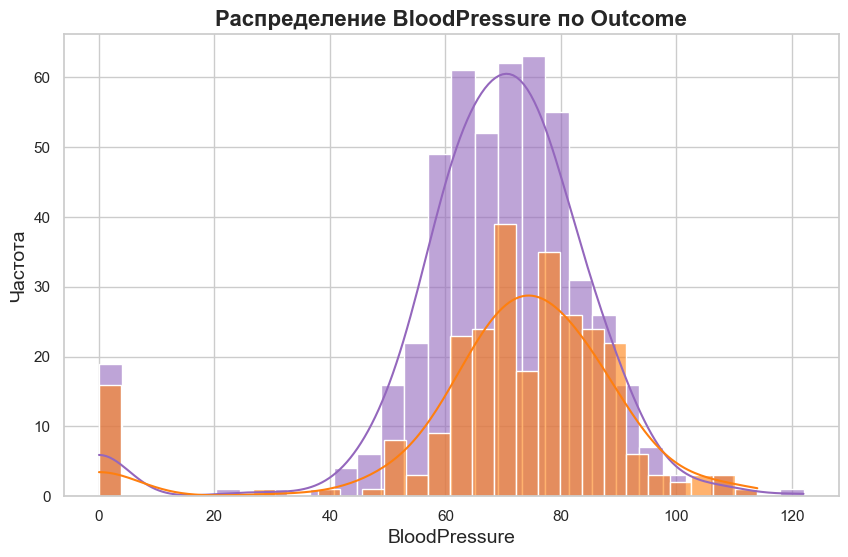

In [53]:
fog(df, 'BloodPressure')

Очень сильно скашивают распределение нулевые значения. Если избавиться от них - распределение будет похоже на нормальное.

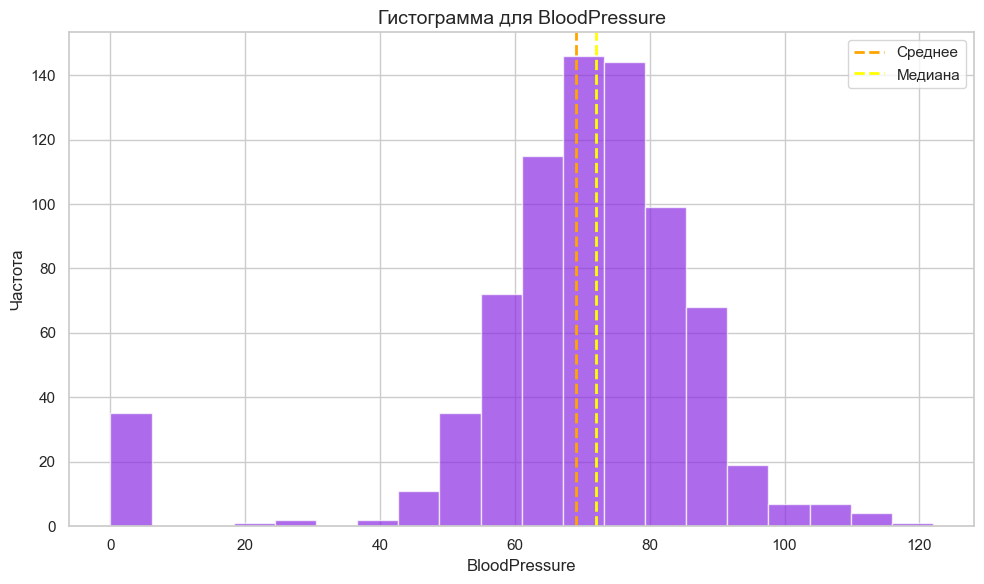

In [55]:
hist_visual(df, 'BloodPressure')

Медиана больше средненго. На данный момент это можно объяснить нулевыми значениями, которые "тянут" среднее вниз. Из-за этого вырисовывается скошенность графика влево. Позже избавимся от нулевых значений и график примет вид нормального распределения.

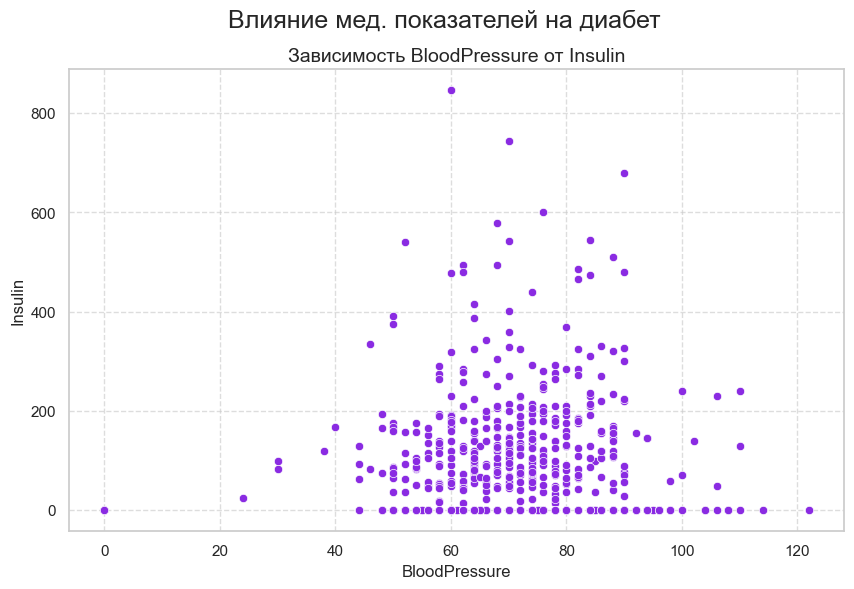

In [57]:
scatter_visual(df, 'BloodPressure', 'Insulin')

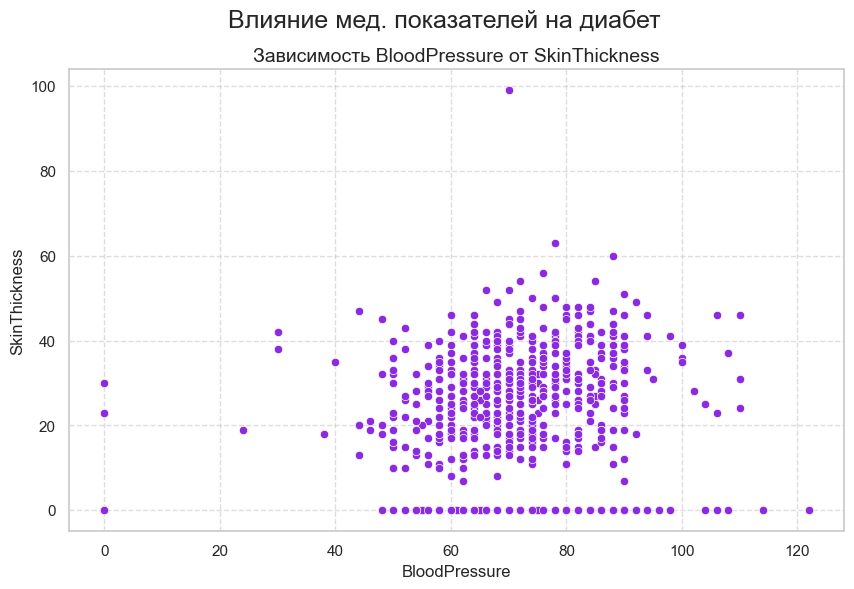

In [58]:
scatter_visual(df, 'BloodPressure', 'SkinThickness')

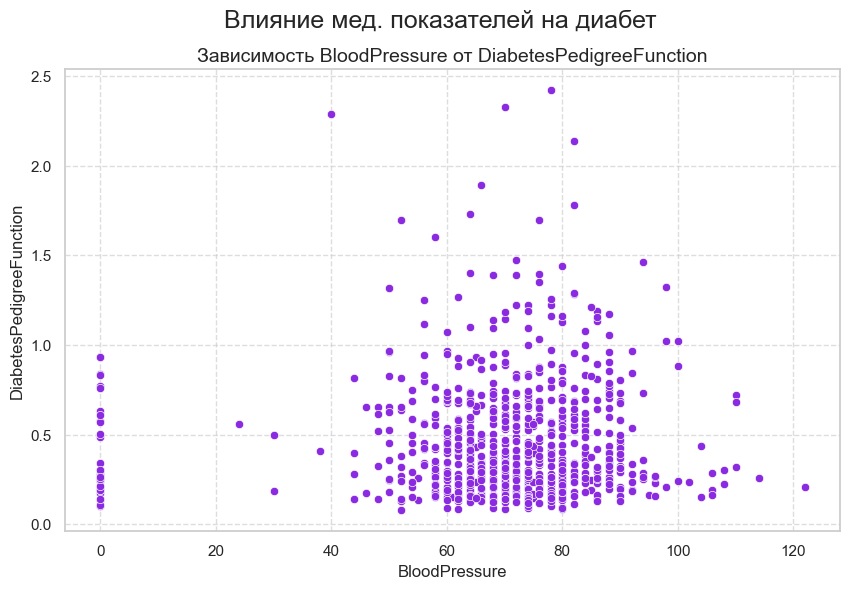

In [59]:
scatter_visual(df, 'BloodPressure', 'DiabetesPedigreeFunction')

Никаких приметных деталей на графиках рассеивания. Это усложняет задачу - модели будет тяжело найти взаимосвязи между признаками. Позже изучим вопрос детальнее и попробуем добавить несколько новых признаков.

In [61]:
feature_analysis(df, 'SkinThickness')

Признак SkinThickness
#=#=#=#=#=#=#=#=#=#
Минимальное значение: 0
#=#=#=#=#=#=#=#=#=#
Среднее значение: 20.536458333333332
#=#=#=#=#=#=#=#=#=#
Максимальное значение: 99
#=#=#=#=#=#=#=#=#=#
Медиана: 23.0
#=#=#=#=#=#=#=#=#=#
Ассиметрия: 0.109158762323673
#=#=#=#=#=#=#=#=#=#
Дисперсия: 254.14189995659854
#=#=#=#=#=#=#=#=#=#
Эксцесс: -0.5244944887652805
#=#=#=#=#=#=#=#=#=#


In [62]:
anomaly(df, 'SkinThickness')

Аномальные значения: 1
579    99
Name: SkinThickness, dtype: int64


579    99
Name: SkinThickness, dtype: int64

In [63]:
df[df['SkinThickness'] == 0]

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
2              8      183             64              0        0  23.3   
5              5      116             74              0        0  25.6   
7             10      115              0              0        0  35.3   
9              8      125             96              0        0   0.0   
10             4      110             92              0        0  37.6   
..           ...      ...            ...            ...      ...   ...   
757            0      123             72              0        0  36.3   
758            1      106             76              0        0  37.5   
759            6      190             92              0        0  35.5   
762            9       89             62              0        0  22.5   
766            1      126             60              0        0  30.1   

     DiabetesPedigreeFunction  Age  Outcome  
2                       0.672   32        1  
5                       0.201   30        0  
7                       0.134   29        0  
9                       0.232   54        1  
10                      0.191   30        0  
..                        ...  ...      ...  
757                     0.258   52        1  
758                     0.197   26        0  
759                     0.278   66        1  
762                     0.142   33        0  
766                     0.349   47        1  

[227 rows x 9 columns]

Функция anomaly выводит всего 1 аномальное значение (Показатель SkinThickness=99). Очень много нулевых значений. По информации из интернета - показатель не может принимать нулевое значение. Разберемся с этими значениями позже.

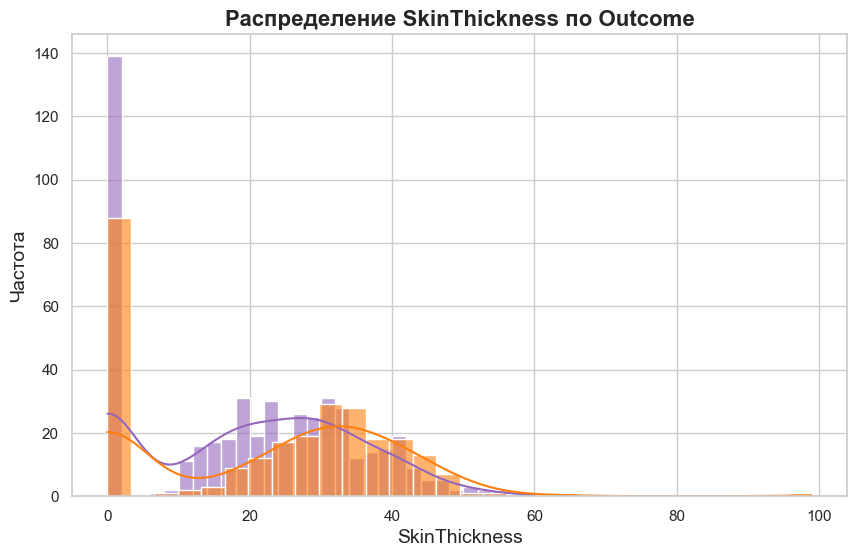

In [65]:
fog(df, 'SkinThickness')

Судя из распределения: SkinThickness никак не влияет на целевую переменную Outcome.

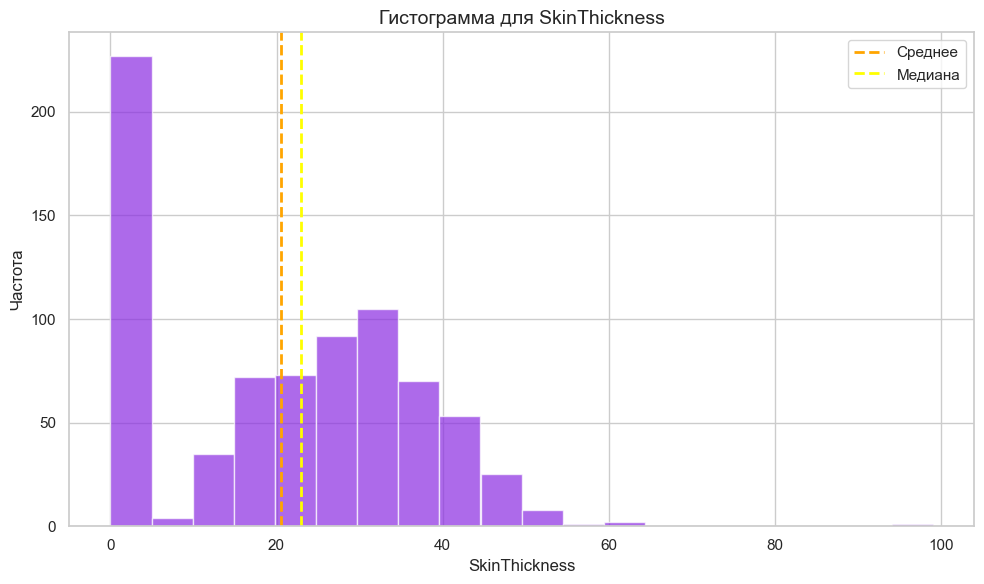

In [67]:
hist_visual(df, 'SkinThickness')

Распределение скошено влево. Медиана больше среднего. Много нулевых значений скашивают график влево.

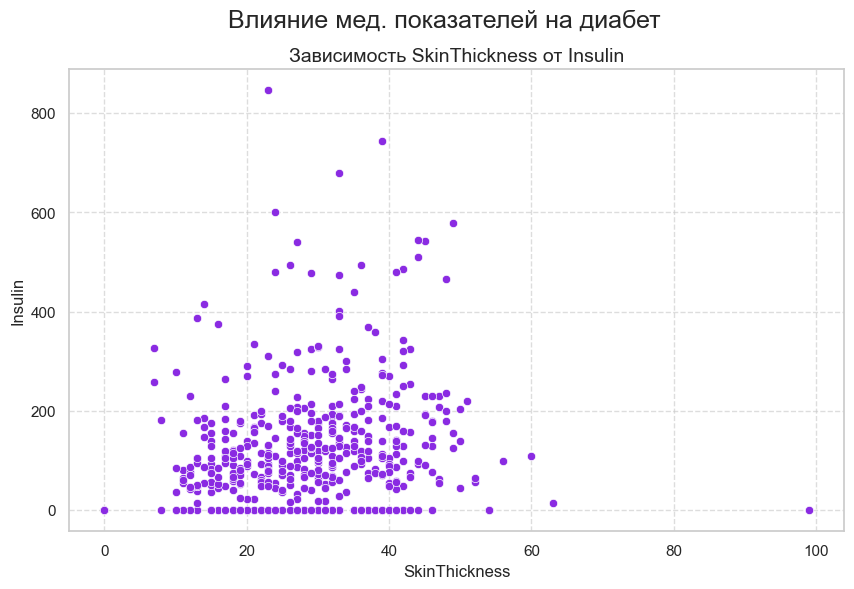

In [69]:
scatter_visual(df, 'SkinThickness', 'Insulin')

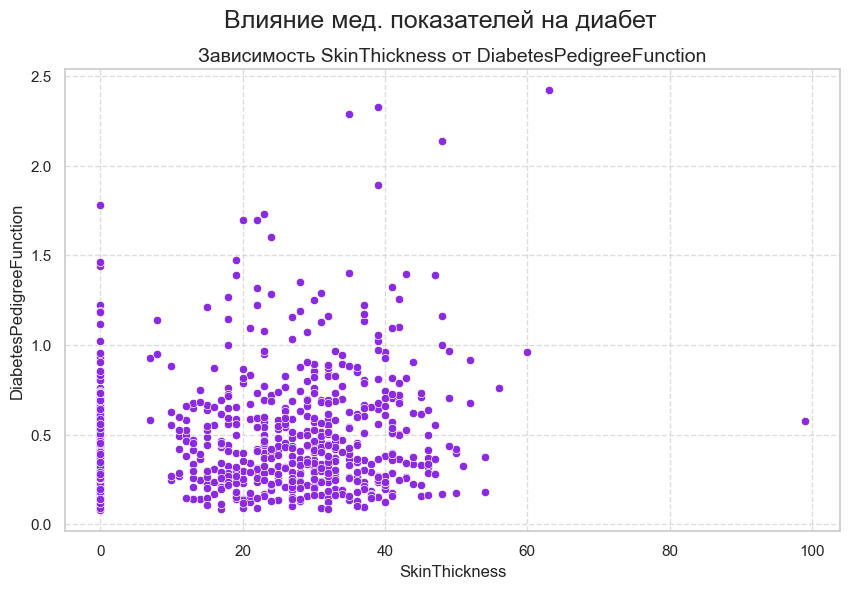

In [70]:
scatter_visual(df, 'SkinThickness', 'DiabetesPedigreeFunction')

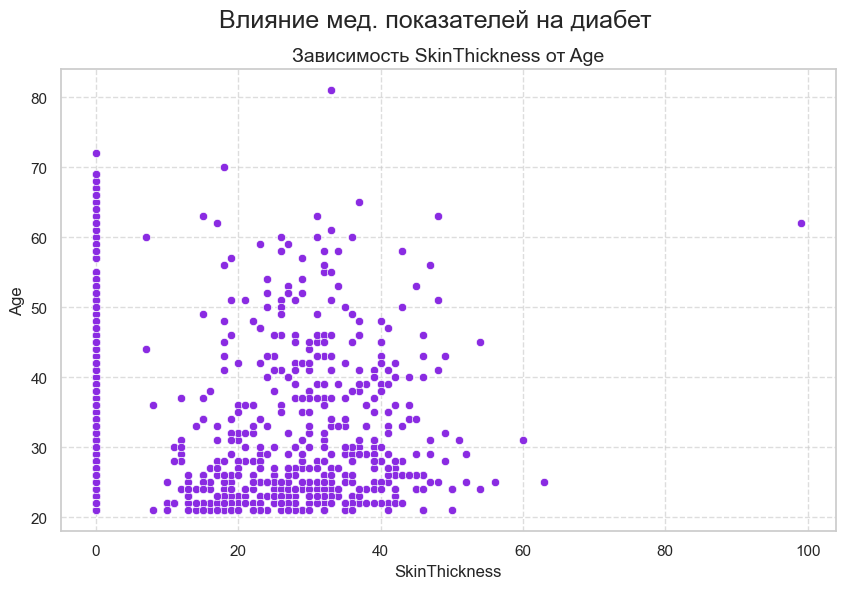

In [71]:
scatter_visual(df, 'SkinThickness', 'Age')

Никаких взаимосвязей. Нжуно будет хорошо подумать, что делать с этим признаком. По сути он не имеет явной корреляции ни с одним из признаков и врядли оказывает значительное влияние на целевую переменную.

In [73]:
feature_analysis(df, 'Insulin')

Признак Insulin
#=#=#=#=#=#=#=#=#=#
Минимальное значение: 0
#=#=#=#=#=#=#=#=#=#
Среднее значение: 79.79947916666667
#=#=#=#=#=#=#=#=#=#
Максимальное значение: 846
#=#=#=#=#=#=#=#=#=#
Медиана: 30.5
#=#=#=#=#=#=#=#=#=#
Ассиметрия: 2.2678104585131753
#=#=#=#=#=#=#=#=#=#
Дисперсия: 13263.886874728778
#=#=#=#=#=#=#=#=#=#
Эксцесс: 7.159574916971424
#=#=#=#=#=#=#=#=#=#


In [74]:
anomaly(df, 'Insulin')

Аномальные значения: 34
8      543
13     846
54     342
111    495
139    325
153    485
186    495
220    478
228    744
231    370
247    680
248    402
258    375
286    545
296    360
360    325
370    465
375    325
392    415
409    579
415    474
480    328
486    480
519    326
574    330
584    600
612    321
645    440
655    540
695    480
707    335
710    387
715    392
753    510
Name: Insulin, dtype: int64


8      543
13     846
54     342
111    495
139    325
153    485
186    495
220    478
228    744
231    370
247    680
248    402
258    375
286    545
296    360
360    325
370    465
375    325
392    415
409    579
415    474
480    328
486    480
519    326
574    330
584    600
612    321
645    440
655    540
695    480
707    335
710    387
715    392
753    510
Name: Insulin, dtype: int64

In [75]:
df[df['Insulin'] == 0]

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
5              5      116             74              0        0  25.6   
7             10      115              0              0        0  35.3   
..           ...      ...            ...            ...      ...   ...   
761            9      170             74             31        0  44.0   
762            9       89             62              0        0  22.5   
764            2      122             70             27        0  36.8   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
5                       0.201   30        0  
7                       0.134   29        0  
..                        ...  ...      ...  
761                     0.403   43        1  
762                     0.142   33        0  
764                     0.340   27        0  
766                     0.349   47        1  
767                     0.315   23        0  

[374 rows x 9 columns]

Тут совсем непонятно: находим 374 нулевых значения и 34 аномальных. Попробуем позже избавиться от них. Некоторые модели чувствительны к подобным значениям и они могут "убить" результативность и эффективность некоторых моделей, которые мы будем использовать.

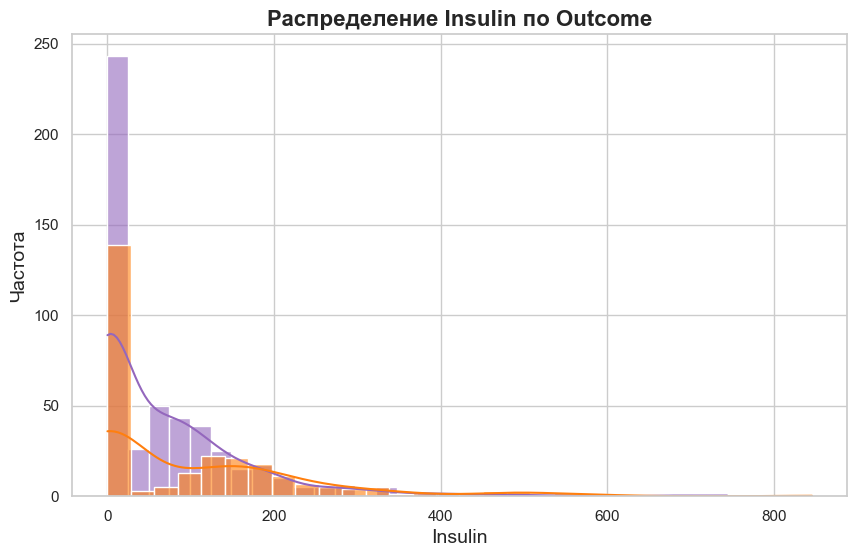

In [77]:
fog(df, 'Insulin')

Заведомо график скошен влево (вспоминаем про 374 нулевых значения). Про связь с целевой переменной: у здоровых людей редко встречается запредельно высокий инсулин.

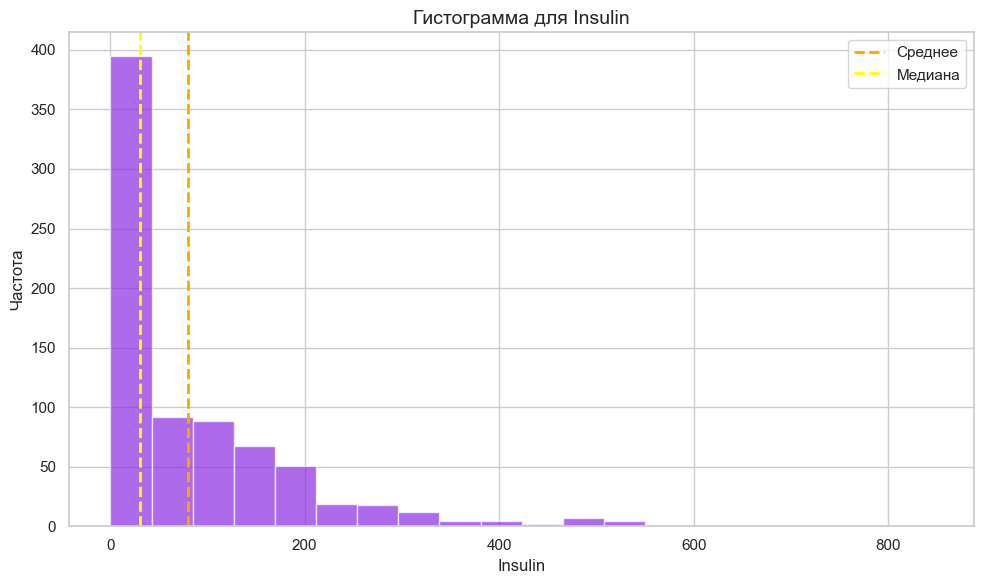

In [79]:
hist_visual(df, 'Insulin')

Очень странно наблюдать тот факт, что среднее больше медианы, при условии 374 нулевых значения из 1000. 

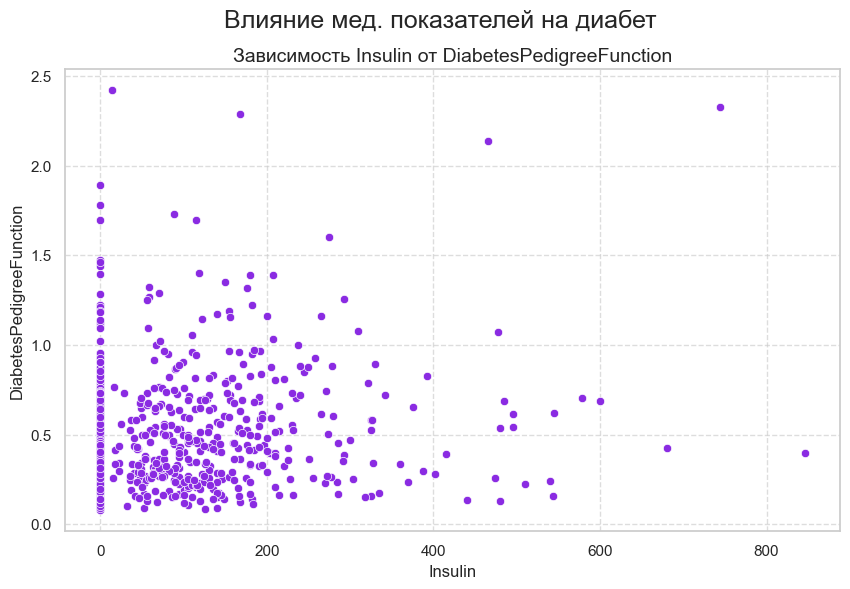

In [81]:
scatter_visual(df, 'Insulin', 'DiabetesPedigreeFunction')

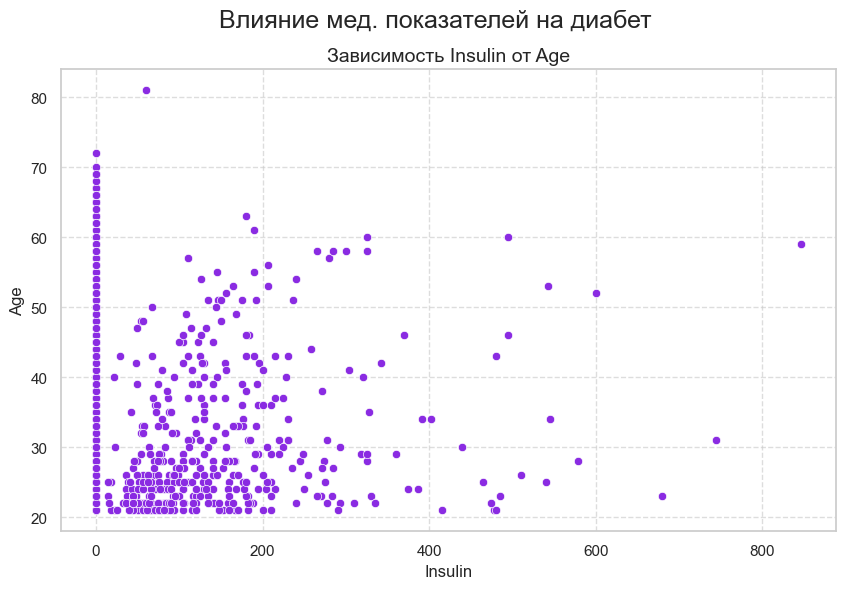

In [82]:
scatter_visual(df, 'Insulin', 'Age')

Взаимосвязи между признаками не увидел.

In [84]:
feature_analysis(df, 'DiabetesPedigreeFunction')

Признак DiabetesPedigreeFunction
#=#=#=#=#=#=#=#=#=#
Минимальное значение: 0.078
#=#=#=#=#=#=#=#=#=#
Среднее значение: 0.47187630208333325
#=#=#=#=#=#=#=#=#=#
Максимальное значение: 2.42
#=#=#=#=#=#=#=#=#=#
Медиана: 0.3725
#=#=#=#=#=#=#=#=#=#
Ассиметрия: 1.9161592037386292
#=#=#=#=#=#=#=#=#=#
Дисперсия: 0.10963569693840873
#=#=#=#=#=#=#=#=#=#
Эксцесс: 5.550792047551203
#=#=#=#=#=#=#=#=#=#


In [85]:
anomaly(df, 'DiabetesPedigreeFunction')

Аномальные значения: 29
4      2.288
12     1.441
39     1.390
45     1.893
58     1.781
100    1.222
147    1.400
187    1.321
218    1.224
228    2.329
243    1.318
245    1.213
259    1.353
292    1.224
308    1.391
330    1.476
370    2.137
371    1.731
383    1.268
395    1.600
445    2.420
534    1.251
593    1.699
606    1.258
618    1.282
621    1.698
622    1.461
659    1.292
661    1.394
Name: DiabetesPedigreeFunction, dtype: float64


4      2.288
12     1.441
39     1.390
45     1.893
58     1.781
100    1.222
147    1.400
187    1.321
218    1.224
228    2.329
243    1.318
245    1.213
259    1.353
292    1.224
308    1.391
330    1.476
370    2.137
371    1.731
383    1.268
395    1.600
445    2.420
534    1.251
593    1.699
606    1.258
618    1.282
621    1.698
622    1.461
659    1.292
661    1.394
Name: DiabetesPedigreeFunction, dtype: float64

Минимальное значение != 0. Находим 29 аномальных значений. Попробуем оценить аномальность значений. Выведем все 29 записей полностью и обратим внимание на целевую переменную Outcome. Признак отвечает за предрасположенность к заболеванию, и если человек с аномально высокой предрасположенностью не болеет - это странно, особенно если таких значений будет много.

In [87]:
min(anomaly(df, 'DiabetesPedigreeFunction'))

Аномальные значения: 29
4      2.288
12     1.441
39     1.390
45     1.893
58     1.781
100    1.222
147    1.400
187    1.321
218    1.224
228    2.329
243    1.318
245    1.213
259    1.353
292    1.224
308    1.391
330    1.476
370    2.137
371    1.731
383    1.268
395    1.600
445    2.420
534    1.251
593    1.699
606    1.258
618    1.282
621    1.698
622    1.461
659    1.292
661    1.394
Name: DiabetesPedigreeFunction, dtype: float64


1.213

In [88]:
df[(df['DiabetesPedigreeFunction'] > 1.213) & (df['Outcome'] == 0)]

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
12            10      139             80              0        0  27.1   
58             0      146             82              0        0  40.5   
147            2      106             64             35      119  30.5   
228            4      197             70             39      744  36.7   
330            8      118             72             19        0  23.1   
371            0      118             64             23       89   0.0   
383            1       90             62             18       59  25.1   
395            2      127             58             24      275  27.7   
534            1       77             56             30       56  33.3   
593            2       82             52             22      115  28.5   
621            2       92             76             20        0  24.2   
622            6      183             94              0        0  40.8   

     DiabetesPedigreeFunction  Age  Outcome  
12                      1.441   57        0  
58                      1.781   44        0  
147                     1.400   34        0  
228                     2.329   31        0  
330                     1.476   46        0  
371                     1.731   21        0  
383                     1.268   25        0  
395                     1.600   25        0  
534                     1.251   24        0  
593                     1.699   25        0  
621                     1.698   28        0  
622                     1.461   45        0

In [89]:
df[(df['DiabetesPedigreeFunction'] > 1.213) & (df['Outcome'] == 1)]

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
4              0      137             40             35      168  43.1   
39             4      111             72             47      207  37.1   
45             0      180             66             39        0  42.0   
100            1      163             72              0        0  39.0   
187            1      128             98             41       58  32.0   
218            5       85             74             22        0  29.0   
243            6      119             50             22      176  27.1   
259           11      155             76             28      150  33.3   
292            2      128             78             37      182  43.3   
308            0      128             68             19      180  30.5   
370            3      173             82             48      465  38.4   
445            0      180             78             63       14  59.4   
606            1      181             78             42      293  40.0   
618            9      112             82             24        0  28.2   
659            3       80             82             31       70  34.2   
661            1      199             76             43        0  42.9   

     DiabetesPedigreeFunction  Age  Outcome  
4                       2.288   33        1  
39                      1.390   56        1  
45                      1.893   25        1  
100                     1.222   33        1  
187                     1.321   33        1  
218                     1.224   32        1  
243                     1.318   33        1  
259                     1.353   51        1  
292                     1.224   31        1  
308                     1.391   25        1  
370                     2.137   25        1  
445                     2.420   25        1  
606                     1.258   22        1  
618                     1.282   50        1  
659                     1.292   27        1  
661                     1.394   22        1

Эта проверка ничего не дала, все по-сути осталось на своем месте, объекты делятся пополам. <br>
Но удалять их или нет? Мы не можем точно сказать, аномальные ли это значения за пределами нашей функции, которая и определяет их аномальными. <br>
Пока что оставим, дальше посмотрим, как они влияют на предсказательную способность модели.

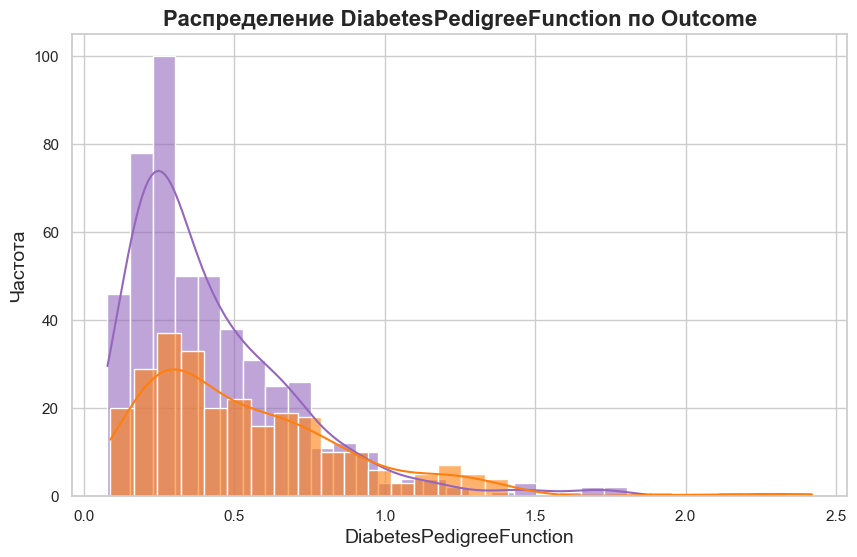

In [91]:
fog(df, 'DiabetesPedigreeFunction')

In [92]:
df[df['DiabetesPedigreeFunction'] > 1.75]

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
4              0      137             40             35      168  43.1   
45             0      180             66             39        0  42.0   
58             0      146             82              0        0  40.5   
228            4      197             70             39      744  36.7   
370            3      173             82             48      465  38.4   
445            0      180             78             63       14  59.4   

     DiabetesPedigreeFunction  Age  Outcome  
4                       2.288   33        1  
45                      1.893   25        1  
58                      1.781   44        0  
228                     2.329   31        0  
370                     2.137   25        1  
445                     2.420   25        1

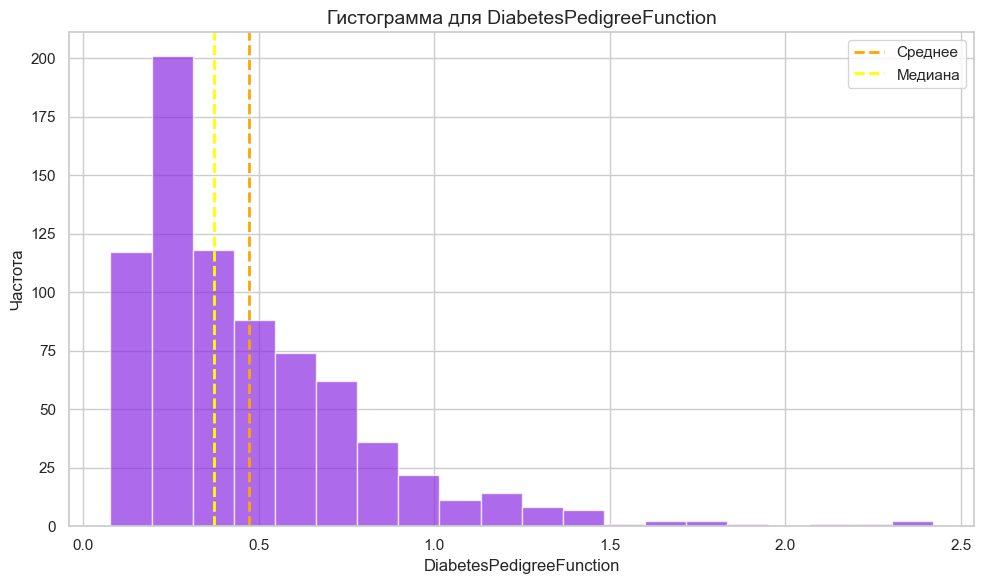

In [93]:
hist_visual(df, 'DiabetesPedigreeFunction')

График скашивают вправо аномально высокие значения. До сих пор нет идей, что с ними делать.

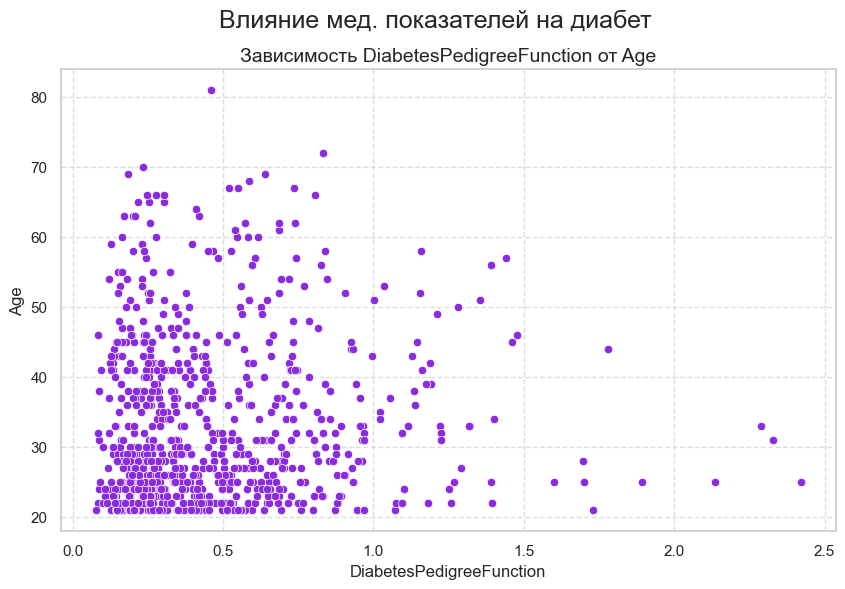

In [95]:
scatter_visual(df, 'DiabetesPedigreeFunction', 'Age')

Нет четких взаимосвязей.

In [97]:
feature_analysis(df, 'Age')

Признак Age
#=#=#=#=#=#=#=#=#=#
Минимальное значение: 21
#=#=#=#=#=#=#=#=#=#
Среднее значение: 33.240885416666664
#=#=#=#=#=#=#=#=#=#
Максимальное значение: 81
#=#=#=#=#=#=#=#=#=#
Медиана: 29.0
#=#=#=#=#=#=#=#=#=#
Ассиметрия: 1.127389259531697
#=#=#=#=#=#=#=#=#=#
Дисперсия: 138.12296379937058
#=#=#=#=#=#=#=#=#=#
Эксцесс: 0.6311769413798585
#=#=#=#=#=#=#=#=#=#


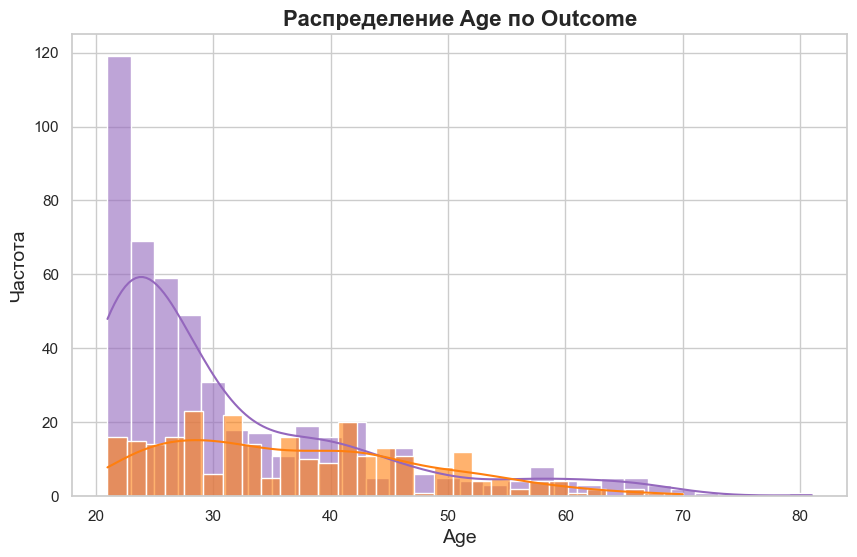

In [98]:
fog(df, 'Age')

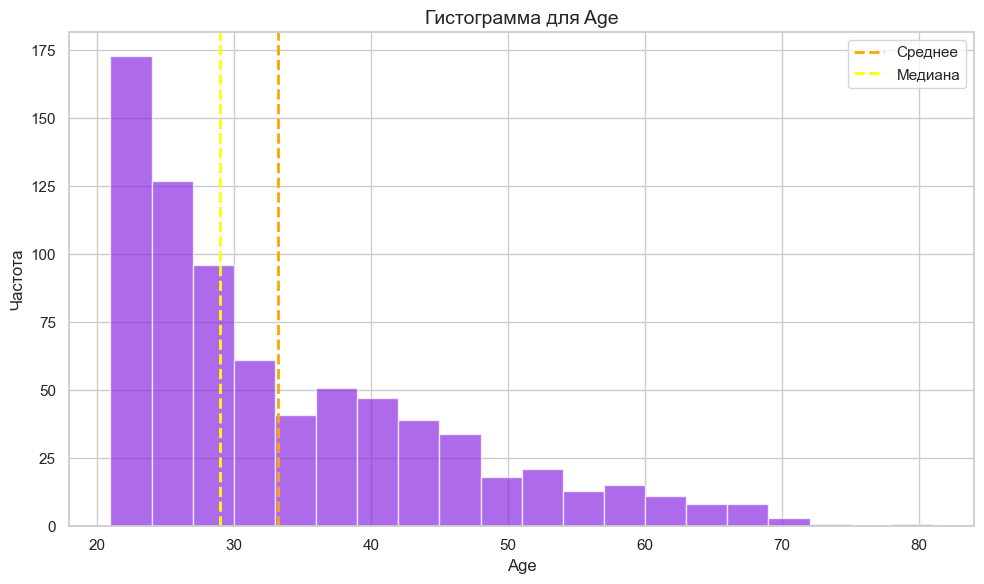

In [99]:
hist_visual(df, 'Age')

Большое количество наблюдений находится в интервале от 20 до 35. У графика длинный хвост справа. <br>
В остальном ничего конкретного сказать нельзя.

<h3>Промежуточные итоги</h3>

1. Взаимосвязи между многими признаками либо отсутствуют, либо они малозначимы.
2. Многие графики имеют ассиметрию.
3. Найдено 4 аномальных значения в Pregnancies.
4. Найдено 5 аномальных значений в Glucose.
6. Найдены нулевые значения в BloodPressure.
7. Найдены аномальные значения в BloodPressure.
8. Найдены нулевые значения в SkinThickness.
9. Найдено аномальное значение в SkinThickness.
10. Найдены аномальные значения в Insulin.
11. Найдены нулевые значения в Insulin.
12. Найдены нулевые значения в Glucose
13. Найдены нулевые значения в BMI.

Очень тяжело связать влияние признаков друг на друга, возможно оно отсутствует. <br>
Нужно избавиться от аномальных и нулевых значений, а также добавить новые признаки. <br>
Далее нужно будет проверить карту корреляции и провести регрессионный анализ признаков. <br>
После обработки и дополнительного изучения признаков приступим к обучению моделей. 

In [102]:
correlation_matrix = df.corr(method='spearman')

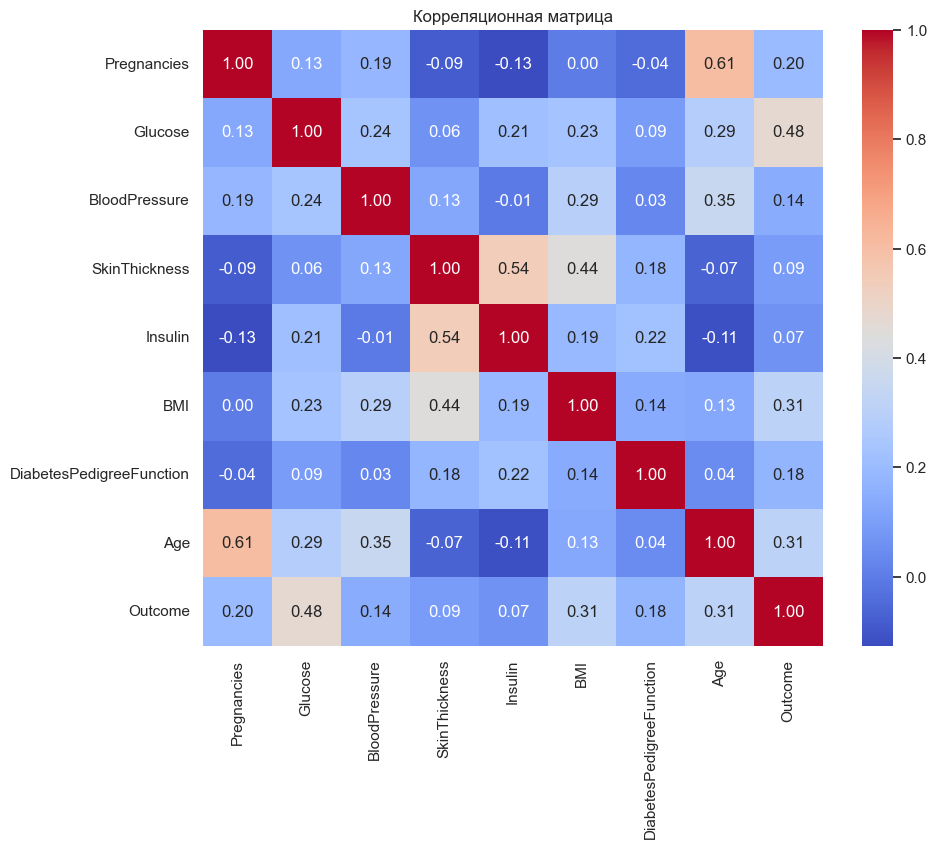

In [103]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

In [104]:
for x in df.drop('Outcome', axis=1).columns:
    print(median_fill(df, x))
    print('-#-#-#-#-#-#-#-#-#-#-#-#-')

   Outcome  Pregnancies
0        0          3.0
1        1          5.0
-#-#-#-#-#-#-#-#-#-#-#-#-
   Outcome  Glucose
0        0    107.0
1        1    140.0
-#-#-#-#-#-#-#-#-#-#-#-#-
   Outcome  BloodPressure
0        0           70.0
1        1           74.5
-#-#-#-#-#-#-#-#-#-#-#-#-
   Outcome  SkinThickness
0        0           27.0
1        1           32.0
-#-#-#-#-#-#-#-#-#-#-#-#-
   Outcome  Insulin
0        0    102.5
1        1    169.5
-#-#-#-#-#-#-#-#-#-#-#-#-
   Outcome   BMI
0        0  30.1
1        1  34.3
-#-#-#-#-#-#-#-#-#-#-#-#-
   Outcome  DiabetesPedigreeFunction
0        0                     0.336
1        1                     0.449
-#-#-#-#-#-#-#-#-#-#-#-#-
   Outcome   Age
0        0  27.0
1        1  36.0
-#-#-#-#-#-#-#-#-#-#-#-#-


Теперь имея медианные значения для всех признаков и подгрупп (Outcome) можем заполнять нулевые значения.

In [106]:
df.loc[(df['BloodPressure'] == 0) & (df['Outcome'] == 0), 'BloodPressure'] = 70.0
df.loc[(df['BloodPressure'] == 0) & (df['Outcome'] == 1), 'BloodPressure'] = 74.5

In [107]:
df.loc[(df['SkinThickness'] == 0) & (df['Outcome'] == 0), 'SkinThickness'] = 27.0
df.loc[(df['SkinThickness'] == 0) & (df['Outcome'] == 1), 'SkinThickness'] = 32.0

In [108]:
df.loc[(df['Insulin'] == 0) & (df['Outcome'] == 0), 'Insulin'] = 102.5
df.loc[(df['Insulin'] == 0) & (df['Outcome'] == 1), 'Insulin'] = 169.5

In [109]:
df.loc[(df['Glucose'] == 0) & (df['Outcome'] == 0), 'Glucose'] = 107.0
df.loc[(df['Glucose'] == 0) & (df['Outcome'] == 1), 'Glucose'] = 140.0

In [110]:
df.loc[(df['BMI'] == 0) & (df['Outcome'] == 0), 'BMI'] = 30.1
df.loc[(df['BMI'] == 0) & (df['Outcome'] == 1), 'BMI'] = 34.3

Рассмотрим аномальные значения.

In [112]:
anomaly_pregnancies = anomaly(df, 'Pregnancies')

Аномальные значения: 4
88     15
159    17
298    14
455    14
Name: Pregnancies, dtype: int64


In [113]:
anomaly_blood_pressure = anomaly(df, 'BloodPressure')

Аномальные значения: 14
18      30.0
43     110.0
84     108.0
106    122.0
125     30.0
177    110.0
362    108.0
549    110.0
597     24.0
599     38.0
658    106.0
662    106.0
672    106.0
691    114.0
Name: BloodPressure, dtype: float64


In [114]:
anomaly_skin_thickness = anomaly(df, 'SkinThickness')

Аномальные значения: 87
8      45
16     47
32     11
39     47
50     11
       ..
698    11
710    13
718    46
753    44
763    48
Name: SkinThickness, Length: 87, dtype: int64


In [115]:
anomaly_insulin = anomaly(df, 'Insulin')

Аномальные значения: 51
8      543.0
13     846.0
53     300.0
54     342.0
56     304.0
111    495.0
139    325.0
144    284.0
153    485.0
162    285.0
186    495.0
199    318.0
206    280.0
215    271.0
220    478.0
228    744.0
231    370.0
247    680.0
248    402.0
258    375.0
279    278.0
286    545.0
296    360.0
360    325.0
364    293.0
370    465.0
375    325.0
388    285.0
392    415.0
395    275.0
409    579.0
412    310.0
415    474.0
425    277.0
480    328.0
486    480.0
519    326.0
561    274.0
574    330.0
584    600.0
606    293.0
608    272.0
612    321.0
645    440.0
655    540.0
695    480.0
707    335.0
710    387.0
713    291.0
715    392.0
753    510.0
Name: Insulin, dtype: float64


Значения, может и аномальные на статистический манер, но почитав про это, могу сказать, что такое вполне допустимо.

<h3>Создание новых признаков</h3>

Ранее, мы убедились, что практически все признаки слабо коррелируют друг с другом и слабо влияют на целевую переменную. Добавим новые признаки.

Для начала проанализируем поведение между Age и другими признаками, и попробуем создать на этой основе новые признаки: по сути вынося в новый признак определенную категорию людей (Категория будет подразумевать под собой возрастную категорию и определенный интервал медицинского показателя)

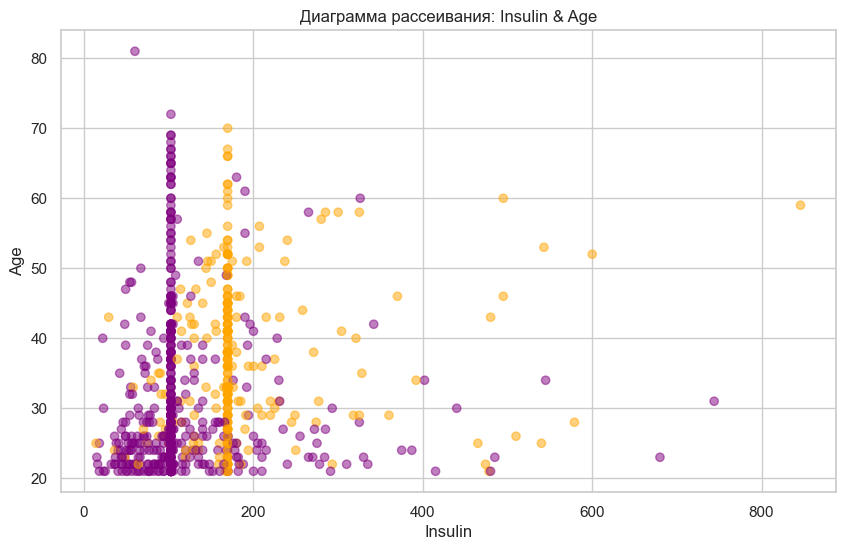

In [119]:
scatter_with_outcome(df, 'Insulin', 'Age')

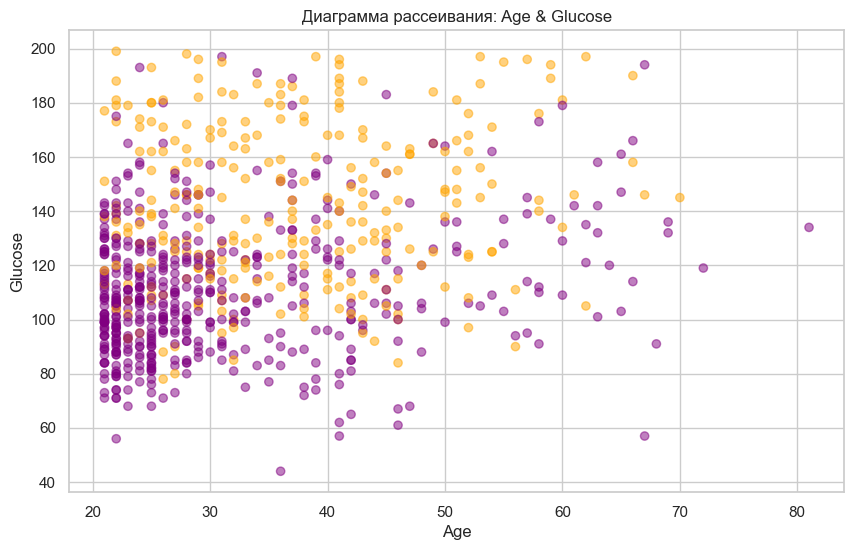

In [120]:
scatter_with_outcome(df, 'Age', 'Glucose')

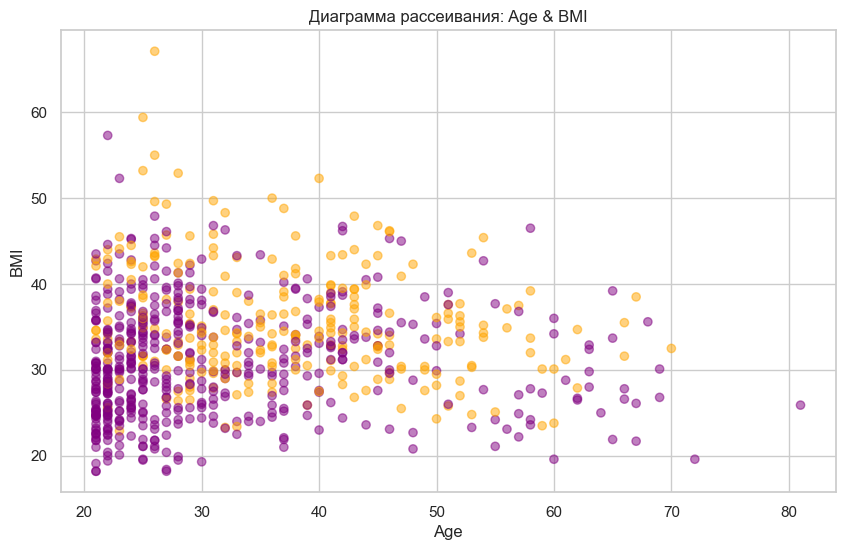

In [121]:
scatter_with_outcome(df, 'Age', 'BMI')

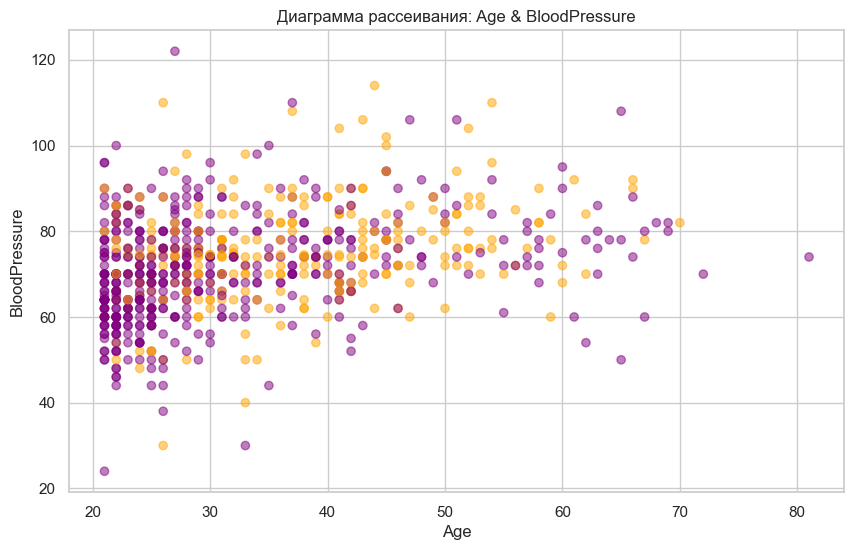

In [122]:
scatter_with_outcome(df, 'Age', 'BloodPressure')

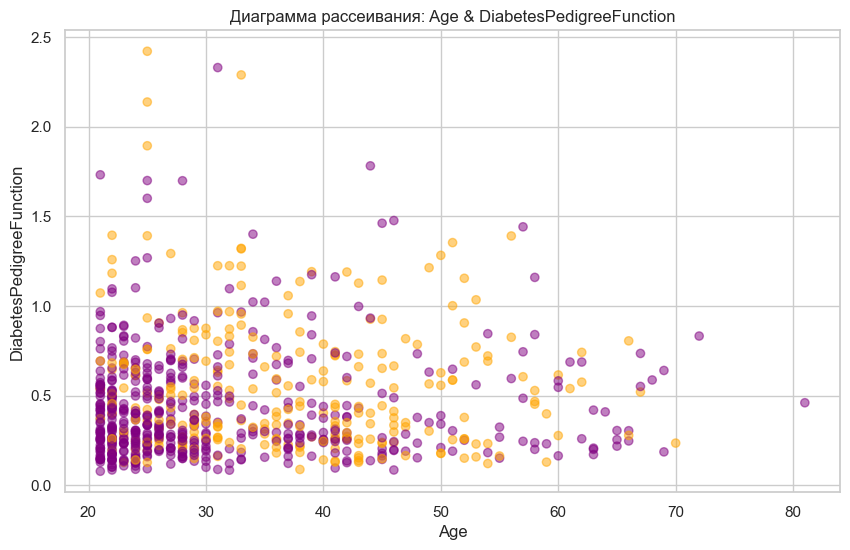

In [123]:
scatter_with_outcome(df, 'Age', 'DiabetesPedigreeFunction')

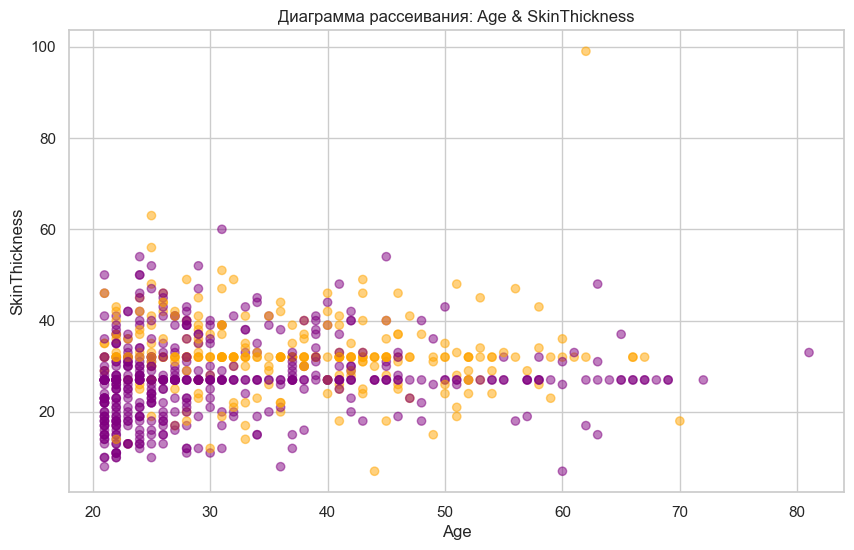

In [124]:
scatter_with_outcome(df, 'Age', 'SkinThickness')

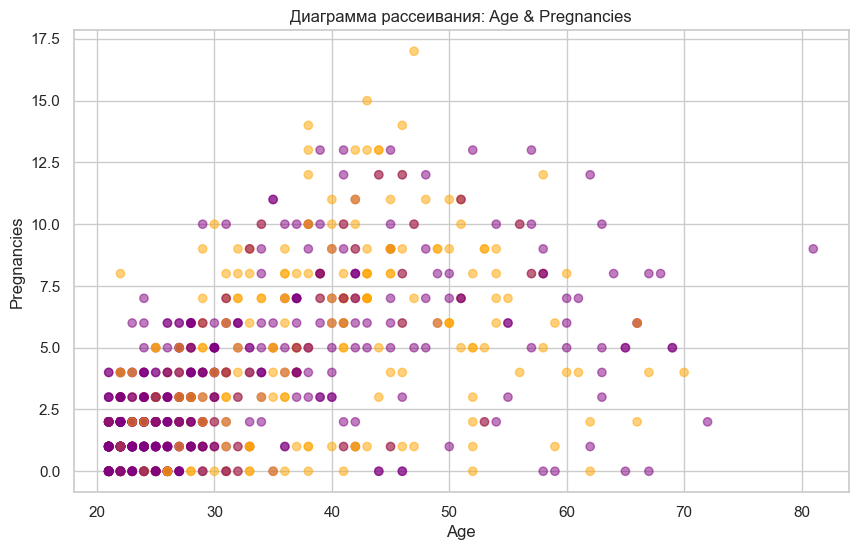

In [125]:
scatter_with_outcome(df, 'Age', 'Pregnancies')

Из этих графиков можно вынести несколько идей для новых признаков:

1. Insulin < 150 & Age < 30 = 1
2. Age < 30 & Glucose < 120 = 1
3. Age < 25 & DiabetesPedigreeFunction < 0.8
4. Age < 30 & Pregnancies <= 5 = 1

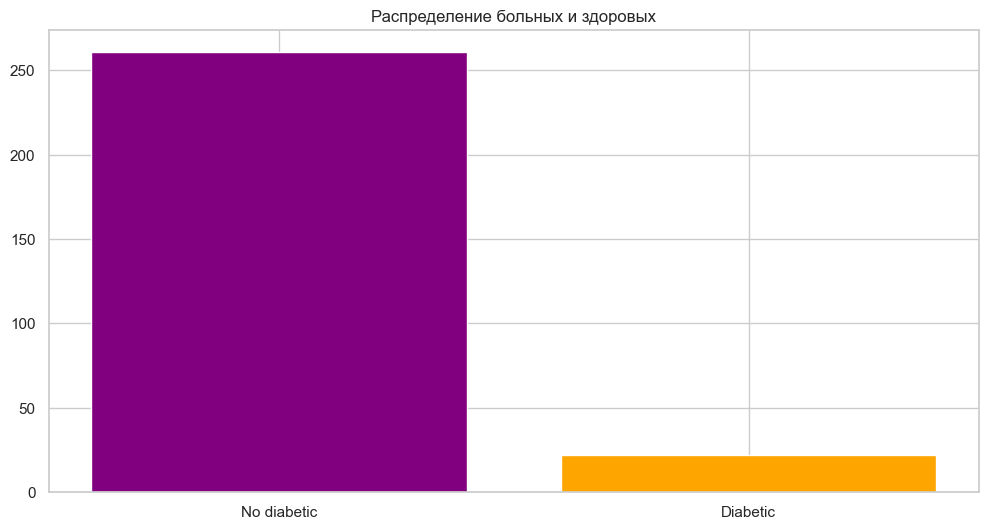

In [127]:
filtered_df_iaa = df[(df['Insulin'] < 150) & (df['Age'] < 30)]
count_outcome_1_iaa = filtered_df_iaa[filtered_df_iaa['Outcome'] == 1].shape[0]
count_outcome_0_iaa = filtered_df_iaa[filtered_df_iaa['Outcome'] == 0].shape[0]
outcomes_iaa = [count_outcome_0_iaa, count_outcome_1_iaa]
labels_iaa = ['No diabetic', 'Diabetic']

plt.figure(figsize=(12, 6))
plt.bar(labels_iaa, outcomes_iaa, color=['purple', 'orange'])
plt.title('Распределение больных и здоровых')
plt.show()

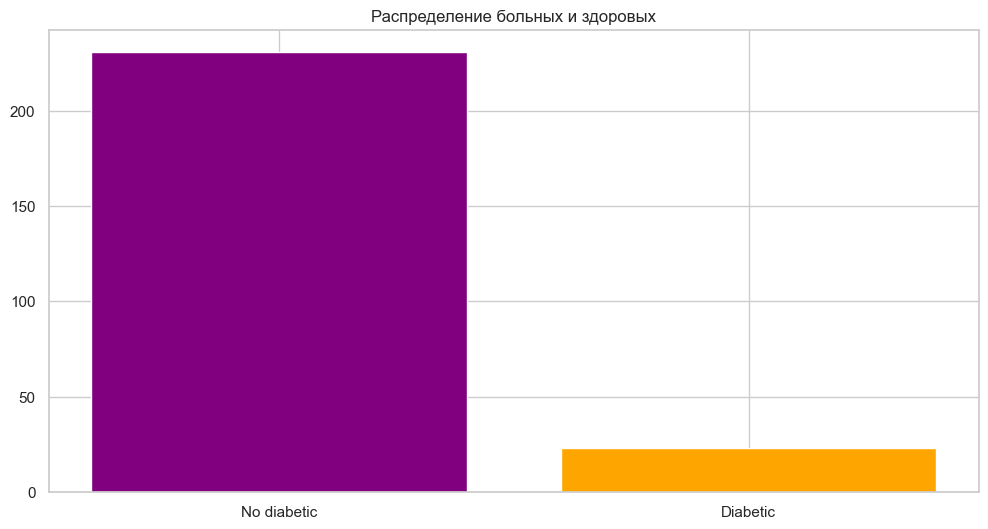

In [128]:
filtered_df_gaa = df[(df['Glucose'] < 120) & (df['Age'] < 30)]
count_outcome_1_gaa = filtered_df_gaa[filtered_df_gaa['Outcome'] == 1].shape[0]
count_outcome_0_gaa = filtered_df_gaa[filtered_df_gaa['Outcome'] == 0].shape[0]
outcomes_gaa = [count_outcome_0_gaa, count_outcome_1_gaa]
labels_gaa = ['No diabetic', 'Diabetic']

plt.figure(figsize=(12, 6))
plt.bar(labels_gaa, outcomes_gaa, color=['purple', 'orange'])
plt.title('Распределение больных и здоровых')
plt.show()

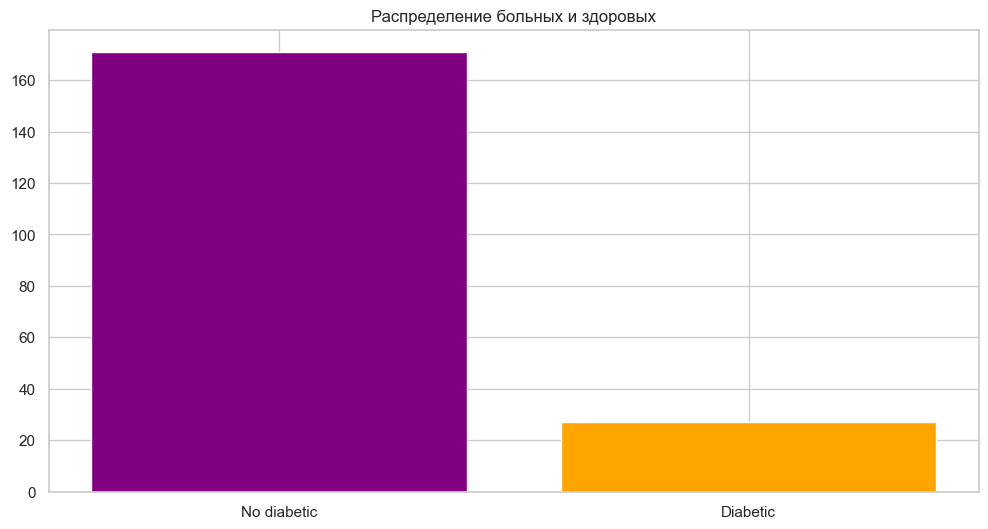

In [129]:
filtered_df_dpfaa = df[(df['DiabetesPedigreeFunction'] < 0.8) & (df['Age'] < 25)]
count_outcome_1_dpfaa = filtered_df_dpfaa[filtered_df_dpfaa['Outcome'] == 1].shape[0]
count_outcome_0_dpfaa = filtered_df_dpfaa[filtered_df_dpfaa['Outcome'] == 0].shape[0]
outcomes_dpfaa = [count_outcome_0_dpfaa, count_outcome_1_dpfaa]
labels_dpfaa = ['No diabetic', 'Diabetic']

plt.figure(figsize=(12, 6))
plt.bar(labels_dpfaa, outcomes_dpfaa, color=['purple', 'orange'])
plt.title('Распределение больных и здоровых')
plt.show()

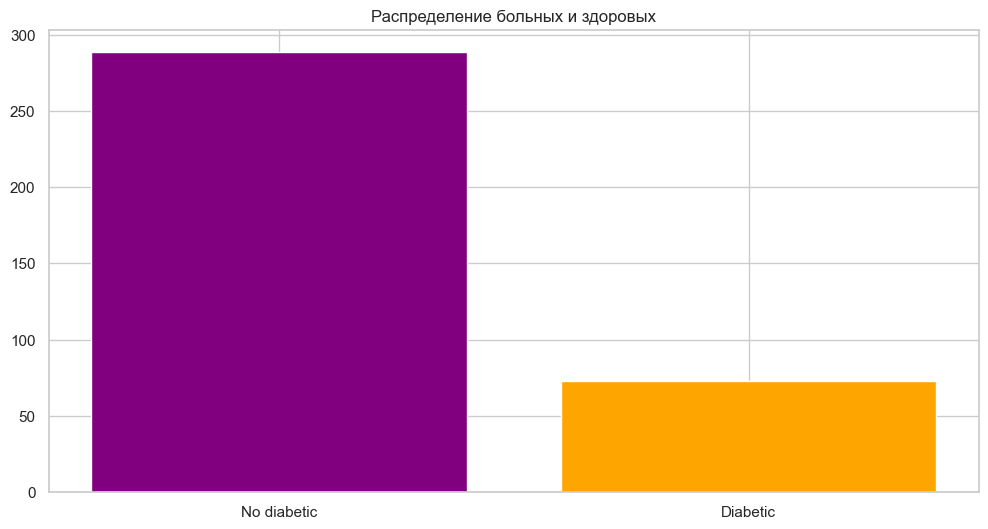

In [130]:
filtered_df_paa = df[(df['Pregnancies'] < 5) & (df['Age'] < 30)]
count_outcome_1_paa = filtered_df_paa[filtered_df_paa['Outcome'] == 1].shape[0]
count_outcome_0_paa = filtered_df_paa[filtered_df_paa['Outcome'] == 0].shape[0]
outcomes_paa = [count_outcome_0_paa, count_outcome_1_paa]
labels_paa = ['No diabetic', 'Diabetic']

plt.figure(figsize=(12, 6))
plt.bar(labels_paa, outcomes_paa, color=['purple', 'orange'])
plt.title('Распределение больных и здоровых')
plt.show()

In [131]:
df = df.assign(IaA='')
df.loc[((df['Insulin'] < 150) & (df['Age'] < 30)), 'IaA'] = 1
df.loc[~((df['Insulin'] < 150) & (df['Age'] < 30)), 'IaA'] = 0

In [132]:
df = df.assign(GaA='')
df.loc[((df['Glucose'] < 120) & (df['Age'] < 30)), 'GaA'] = 1
df.loc[~((df['Glucose'] < 120) & (df['Age'] < 30)), 'GaA'] = 0

In [133]:
df = df.assign(DPFaA='')
df.loc[((df['DiabetesPedigreeFunction'] < 0.8) & (df['Age'] < 25)), 'DPFaA'] = 1
df.loc[~((df['DiabetesPedigreeFunction'] < 0.8) & (df['Age'] < 25)), 'DPFaA'] = 0

In [134]:
df = df.assign(PaA='')
df.loc[((df['Pregnancies'] <= 5) & (df['Age'] < 30)), 'PaA'] = 1
df.loc[~((df['Pregnancies'] <= 5) & (df['Age'] < 30)), 'PaA'] = 0

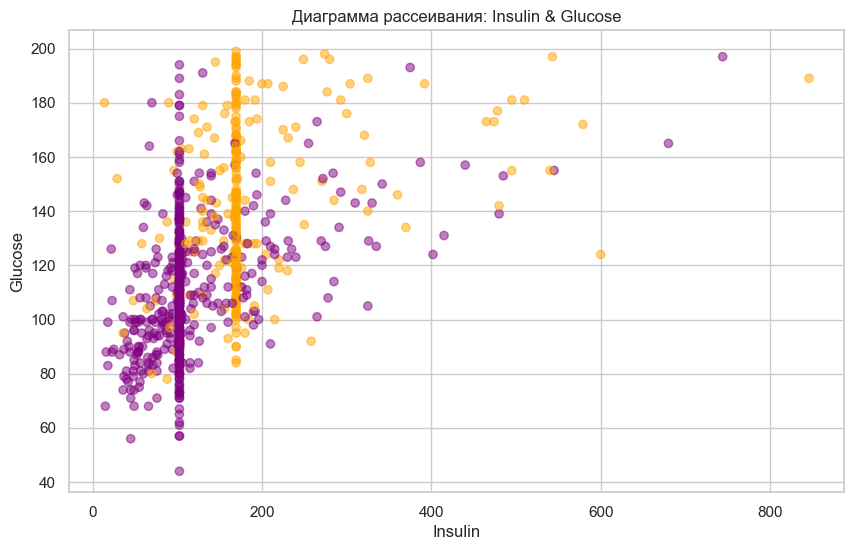

In [135]:
scatter_with_outcome(df, 'Insulin', 'Glucose')

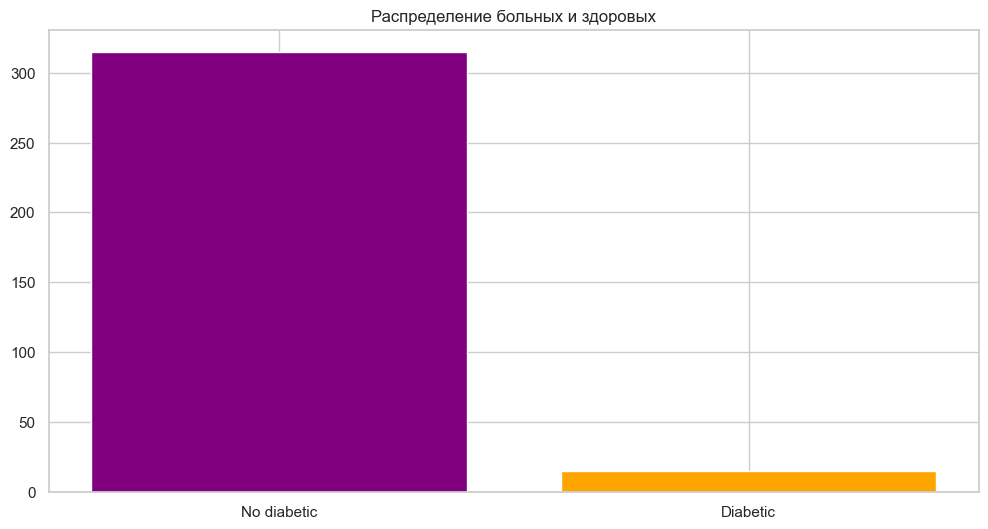

In [136]:
filtered_df_iag = df[(df['Insulin'] < 150) & (df['Glucose'] < 120)]
count_outcome_1_iag = filtered_df_iag[filtered_df_iag['Outcome'] == 1].shape[0]
count_outcome_0_iag = filtered_df_iag[filtered_df_iag['Outcome'] == 0].shape[0]
outcomes_iag = [count_outcome_0_iag, count_outcome_1_iag]
labels_iag = ['No diabetic', 'Diabetic']

plt.figure(figsize=(12, 6))
plt.bar(labels_iag, outcomes_iag, color=['purple', 'orange'])
plt.title('Распределение больных и здоровых')
plt.show()

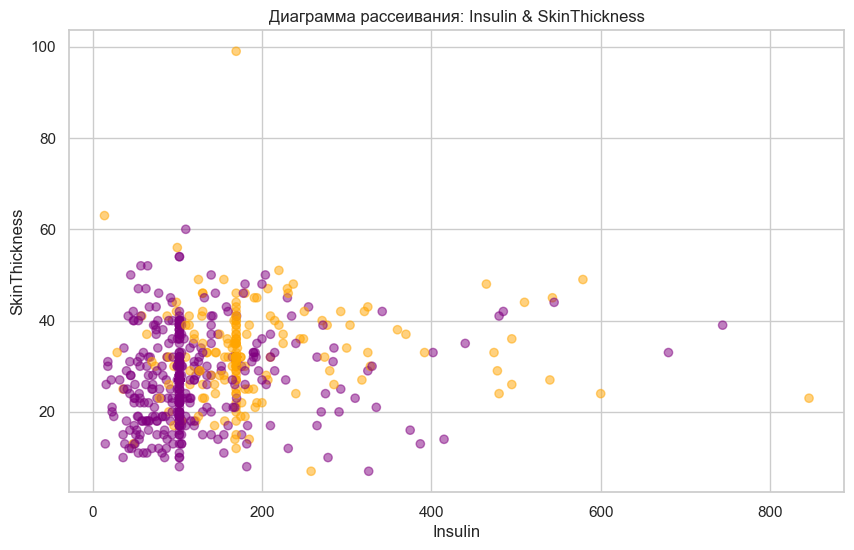

In [137]:
scatter_with_outcome(df, 'Insulin', 'SkinThickness')

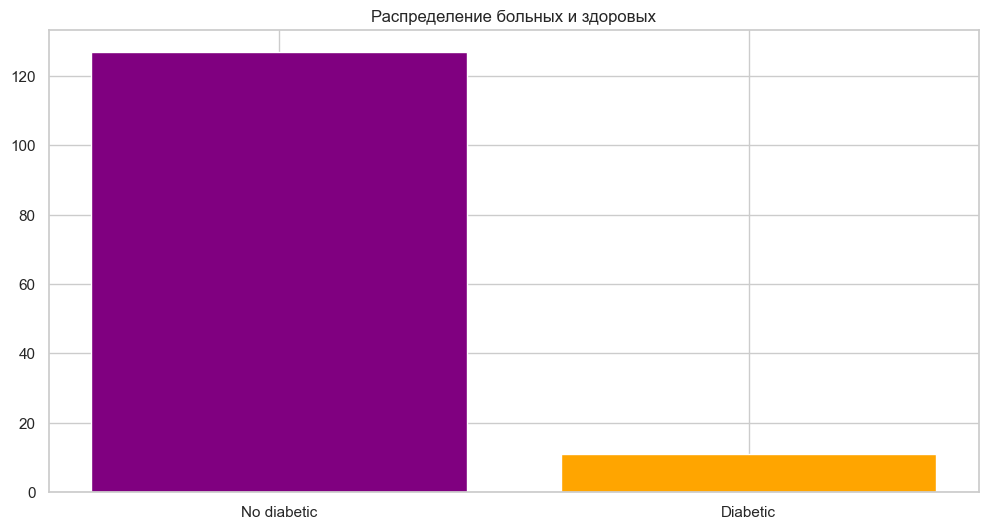

In [138]:
filtered_df_iast = df[(df['Insulin'] < 150) & (df['SkinThickness'] < 25)]
count_outcome_1_iast = filtered_df_iast[filtered_df_iast['Outcome'] == 1].shape[0]
count_outcome_0_iast = filtered_df_iast[filtered_df_iast['Outcome'] == 0].shape[0]
outcomes_iast = [count_outcome_0_iast, count_outcome_1_iast]
labels_iast = ['No diabetic', 'Diabetic']

plt.figure(figsize=(12, 6))
plt.bar(labels_iast, outcomes_iast, color=['purple', 'orange'])
plt.title('Распределение больных и здоровых')
plt.show()

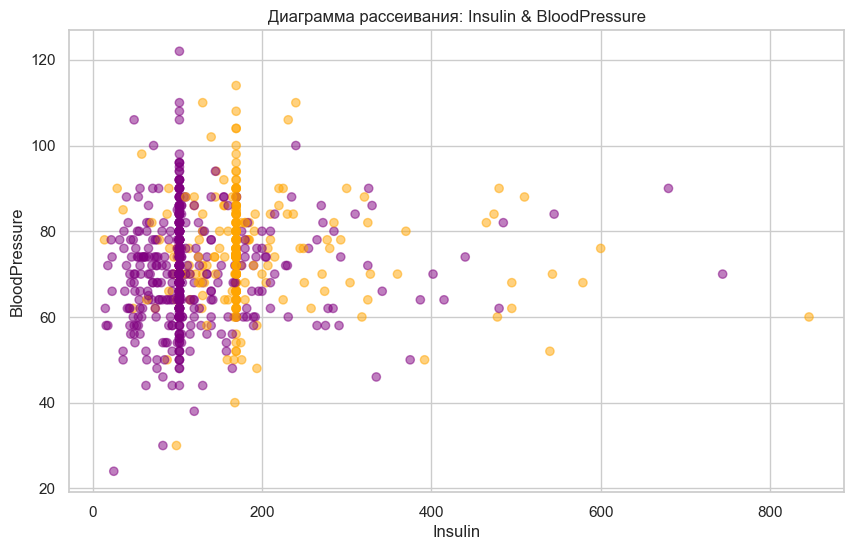

In [139]:
scatter_with_outcome(df, 'Insulin', 'BloodPressure')

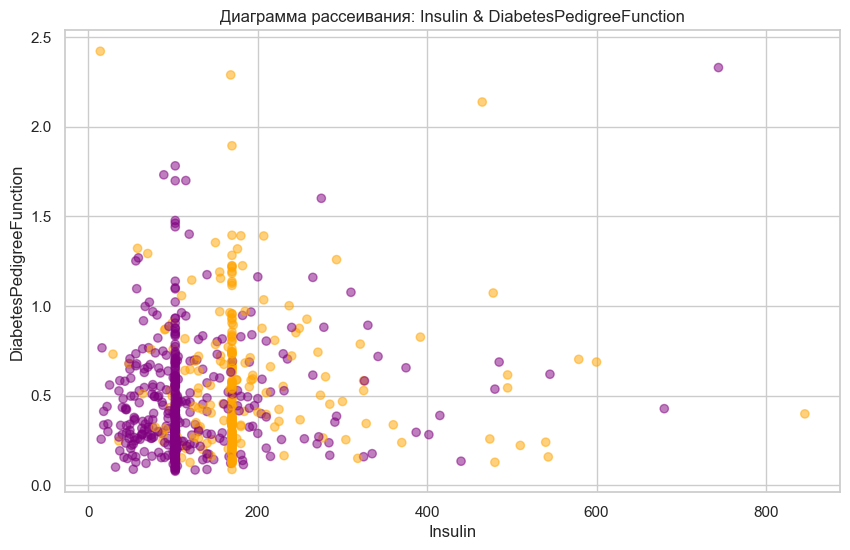

In [140]:
scatter_with_outcome(df, 'Insulin', 'DiabetesPedigreeFunction')

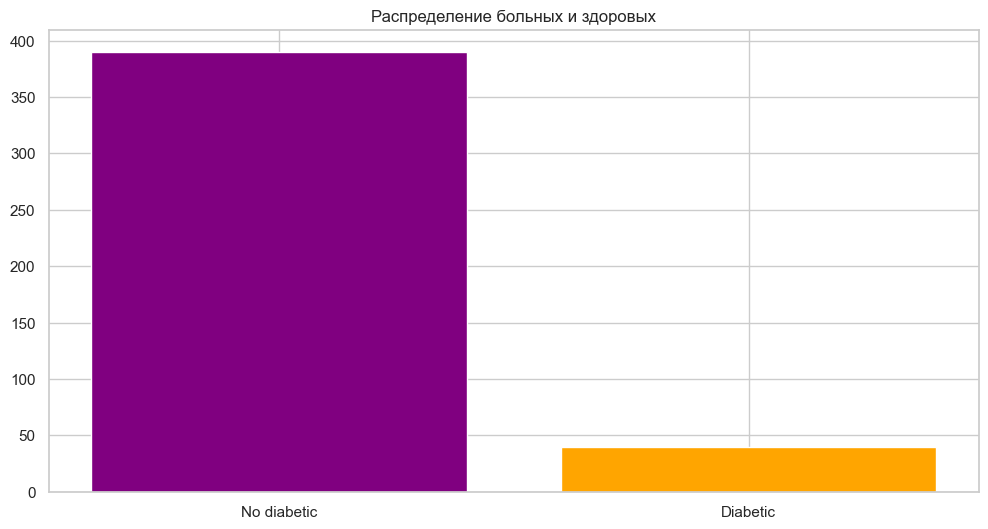

In [141]:
filtered_df_iadpf = df[(df['Insulin'] < 150) & (df['DiabetesPedigreeFunction'] < 0.8)]
count_outcome_1_iadpf = filtered_df_iadpf[filtered_df_iadpf['Outcome'] == 1].shape[0]
count_outcome_0_iadpf = filtered_df_iadpf[filtered_df_iadpf['Outcome'] == 0].shape[0]
outcomes_iadpf = [count_outcome_0_iadpf, count_outcome_1_iadpf]
labels_iadpf = ['No diabetic', 'Diabetic']

plt.figure(figsize=(12, 6))
plt.bar(labels_iadpf, outcomes_iadpf, color=['purple', 'orange'])
plt.title('Распределение больных и здоровых')
plt.show()

<h3>Новые признаки ч.2</h3>

1. Insulin < 150 & Glucose < 120 = 1
2. Insulin < 150 & SkinThickness < 25 = 1
3. Insulin < 150 & DiabetesPedigreeFunction < 0.8 = 1

In [143]:
df = df.assign(IaG='')
df.loc[((df['Insulin'] < 150) & (df['Glucose'] < 120)), 'IaG'] = 1
df.loc[~((df['Insulin'] < 150) & (df['Glucose'] < 120)), 'IaG'] = 0

In [144]:
df = df.assign(IaDPF='')
df.loc[((df['Insulin'] < 150) & (df['DiabetesPedigreeFunction'] < 0.8)), 'IaDPF'] = 1
df.loc[~((df['Insulin'] < 150) & (df['DiabetesPedigreeFunction'] < 0.8)), 'IaDPF'] = 0

In [145]:
df = df.assign(IaST='')
df.loc[((df['Insulin'] < 150) & (df['SkinThickness'] < 25)), 'IaST'] = 1
df.loc[~((df['Insulin'] < 150) & (df['SkinThickness'] < 25)), 'IaST'] = 0

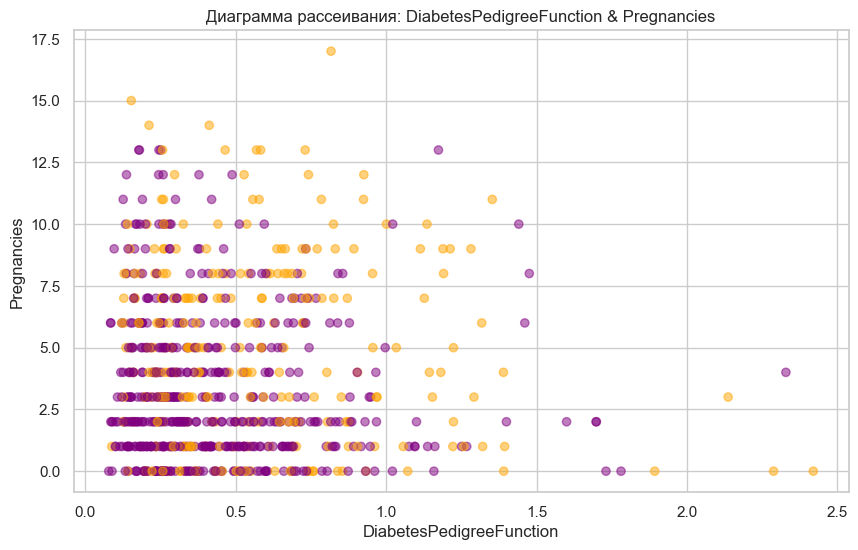

In [146]:
scatter_with_outcome(df, 'DiabetesPedigreeFunction', 'Pregnancies')

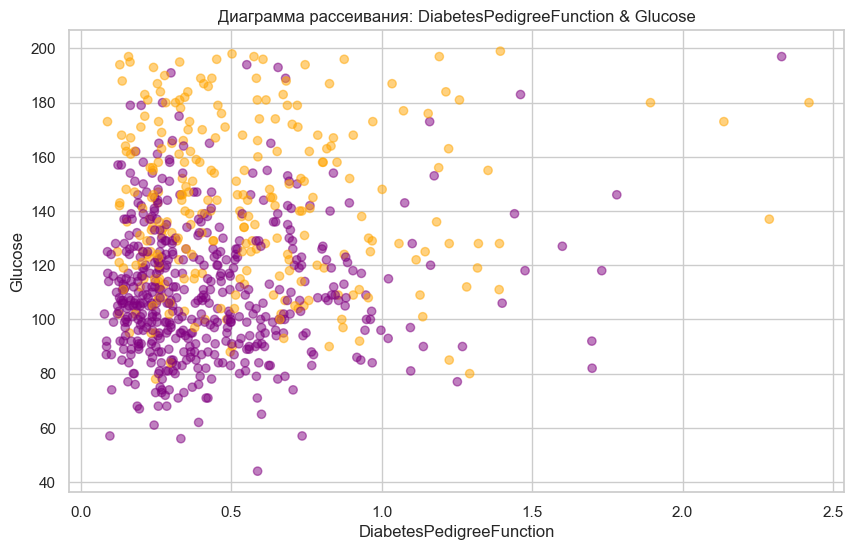

In [147]:
scatter_with_outcome(df, 'DiabetesPedigreeFunction', 'Glucose')

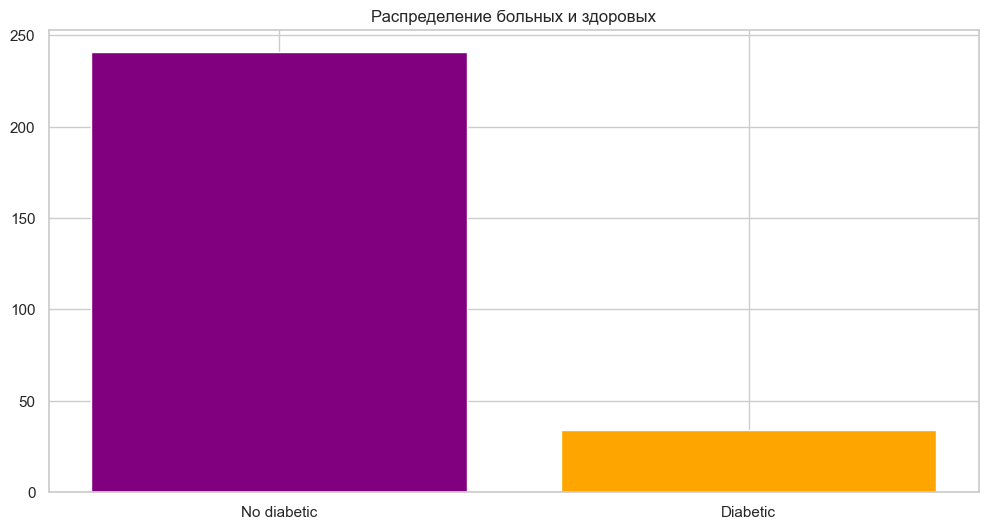

In [148]:
filtered_df_gadpf = df[(df['Glucose'] < 120) & (df['DiabetesPedigreeFunction'] < 0.5)]
count_outcome_1_gadpf = filtered_df_gadpf[filtered_df_gadpf['Outcome'] == 1].shape[0]
count_outcome_0_gadpf = filtered_df_gadpf[filtered_df_gadpf['Outcome'] == 0].shape[0]
outcomes_gadpf = [count_outcome_0_gadpf, count_outcome_1_gadpf]
labels_gadpf = ['No diabetic', 'Diabetic']

plt.figure(figsize=(12, 6))
plt.bar(labels_gadpf, outcomes_gadpf, color=['purple', 'orange'])
plt.title('Распределение больных и здоровых')
plt.show()

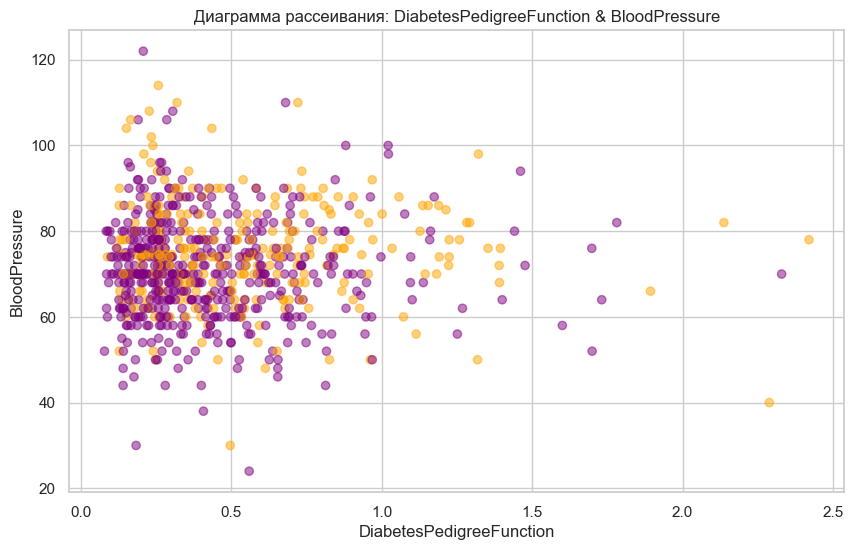

In [149]:
scatter_with_outcome(df, 'DiabetesPedigreeFunction', 'BloodPressure')

Новый признак: Glucose < 120 & DiabetesPedigreeFunction < 0.5

In [151]:
df = df.assign(GaDPF='')
df.loc[((df['Glucose'] < 120) & (df['DiabetesPedigreeFunction'] < 0.5)), 'GaDPF'] = 1
df.loc[~((df['Glucose'] < 120) & (df['DiabetesPedigreeFunction'] < 0.5)), 'GaDPF'] = 0

In [152]:
df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148           72.0             35    169.5  33.6   
1              1       85           66.0             29    102.5  26.6   
2              8      183           64.0             32    169.5  23.3   
3              1       89           66.0             23     94.0  28.1   
4              0      137           40.0             35    168.0  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101           76.0             48    180.0  32.9   
764            2      122           70.0             27    102.5  36.8   
765            5      121           72.0             23    112.0  26.2   
766            1      126           60.0             32    169.5  30.1   
767            1       93           70.0             31    102.5  30.4   

     DiabetesPedigreeFunction  Age  Outcome IaA GaA DPFaA PaA IaG IaDPF IaST  \
0                       0.627   50        1   0   0     0   0   0     0    0   
1                       0.351   31        0   0   0     0   0   1     1    0   
2                       0.672   32        1   0   0     0   0   0     0    0   
3                       0.167   21        0   1   1     1   1   1     1    1   
4                       2.288   33        1   0   0     0   0   0     0    0   
..                        ...  ...      ...  ..  ..   ...  ..  ..   ...  ...   
763                     0.171   63        0   0   0     0   0   0     0    0   
764                     0.340   27        0   1   0     0   1   0     1    0   
765                     0.245   30        0   0   0     0   0   0     1    1   
766                     0.349   47        1   0   0     0   0   0     0    0   
767                     0.315   23        0   1   1     1   1   1     1    0   

    GaDPF  
0       0  
1       1  
2       0  
3       1  
4       0  
..    ...  
763     1  
764     0  
765     0  
766     0  
767     1  

[768 rows x 17 columns]

In [153]:
df['IaA'] = df['IaA'].astype(float)
df['GaA'] = df['GaA'].astype(float)
df['DPFaA'] = df['DPFaA'].astype(float)
df['PaA'] = df['PaA'].astype(float)
df['IaG'] = df['IaG'].astype(float)
df['IaST'] = df['IaST'].astype(float)
df['IaDPF'] = df['IaDPF'].astype(float)
df['GaDPF'] = df['GaDPF'].astype(float)

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
 9   IaA                       768 non-null    float64
 10  GaA                       768 non-null    float64
 11  DPFaA                     768 non-null    float64
 12  PaA                       768 non-null    float64
 13  IaG                       768 non-null    float64
 14  IaDPF     

<h3>Обучение модели</h3>

In [156]:
df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148           72.0             35    169.5  33.6   
1              1       85           66.0             29    102.5  26.6   
2              8      183           64.0             32    169.5  23.3   
3              1       89           66.0             23     94.0  28.1   
4              0      137           40.0             35    168.0  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101           76.0             48    180.0  32.9   
764            2      122           70.0             27    102.5  36.8   
765            5      121           72.0             23    112.0  26.2   
766            1      126           60.0             32    169.5  30.1   
767            1       93           70.0             31    102.5  30.4   

     DiabetesPedigreeFunction  Age  Outcome  IaA  GaA  DPFaA  PaA  IaG  IaDPF  \
0                       0.627   50        1  0.0  0.0    0.0  0.0  0.0    0.0   
1                       0.351   31        0  0.0  0.0    0.0  0.0  1.0    1.0   
2                       0.672   32        1  0.0  0.0    0.0  0.0  0.0    0.0   
3                       0.167   21        0  1.0  1.0    1.0  1.0  1.0    1.0   
4                       2.288   33        1  0.0  0.0    0.0  0.0  0.0    0.0   
..                        ...  ...      ...  ...  ...    ...  ...  ...    ...   
763                     0.171   63        0  0.0  0.0    0.0  0.0  0.0    0.0   
764                     0.340   27        0  1.0  0.0    0.0  1.0  0.0    1.0   
765                     0.245   30        0  0.0  0.0    0.0  0.0  0.0    1.0   
766                     0.349   47        1  0.0  0.0    0.0  0.0  0.0    0.0   
767                     0.315   23        0  1.0  1.0    1.0  1.0  1.0    1.0   

     IaST  GaDPF  
0     0.0    0.0  
1     0.0    1.0  
2     0.0    0.0  
3     1.0    1.0  
4     0.0    0.0  
..    ...    ...  
763   0.0    1.0  
764   0.0    0.0  
765   1.0    0.0  
766   0.0    0.0  
767   0.0    1.0  

[768 rows x 17 columns]

In [157]:
target = ['Outcome']
numerical_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
bin_cols = ['IaA', 'GaA', 'DPFaA', 'PaA', 'IaG', 'IaDPF', 'IaST', 'GaDPF']

le = LabelEncoder()

for col in bin_cols:
    df[col] = le.fit_transform(df[col])

scaler = StandardScaler()
scaled = scaler.fit_transform(df[numerical_cols])
scaled = pd.DataFrame(scaled,columns=numerical_cols)

df = df.drop(columns = numerical_cols,axis = 1)
df = df.merge(scaled,left_index=True,right_index=True,how = "left")

In [158]:
df.head()

Outcome  IaA  GaA  DPFaA  PaA  IaG  IaDPF  IaST  GaDPF  Pregnancies  \
0        1    0    0      0    0    0      0     0      0     0.639947   
1        0    0    0      0    0    1      1     0      1    -0.844885   
2        1    0    0      0    0    0      0     0      0     1.233880   
3        0    1    1      1    1    1      1     1      1    -0.844885   
4        1    0    0      0    0    0      0     0      0    -1.141852   

    Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0  0.864625      -0.032180       0.665181  0.311604  0.169483   
1 -1.204727      -0.528124      -0.010112 -0.440843 -0.848549   
2  2.014265      -0.693438       0.327535  0.311604 -1.328478   
3 -1.073339      -0.528124      -0.685405 -0.536303 -0.630399   
4  0.503310      -2.677212       0.665181  0.294758  1.551096   

   DiabetesPedigreeFunction       Age  
0                  0.468492  1.425995  
1                 -0.365061 -0.190672  
2                  0.604397 -0.105584  
3                 -0.920763 -1.041549  
4                  5.484909 -0.020496

In [159]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [343]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
predict_rfc = rfc.predict(X_test)
print(accuracy_score(y_test, predict_rfc))

0.875


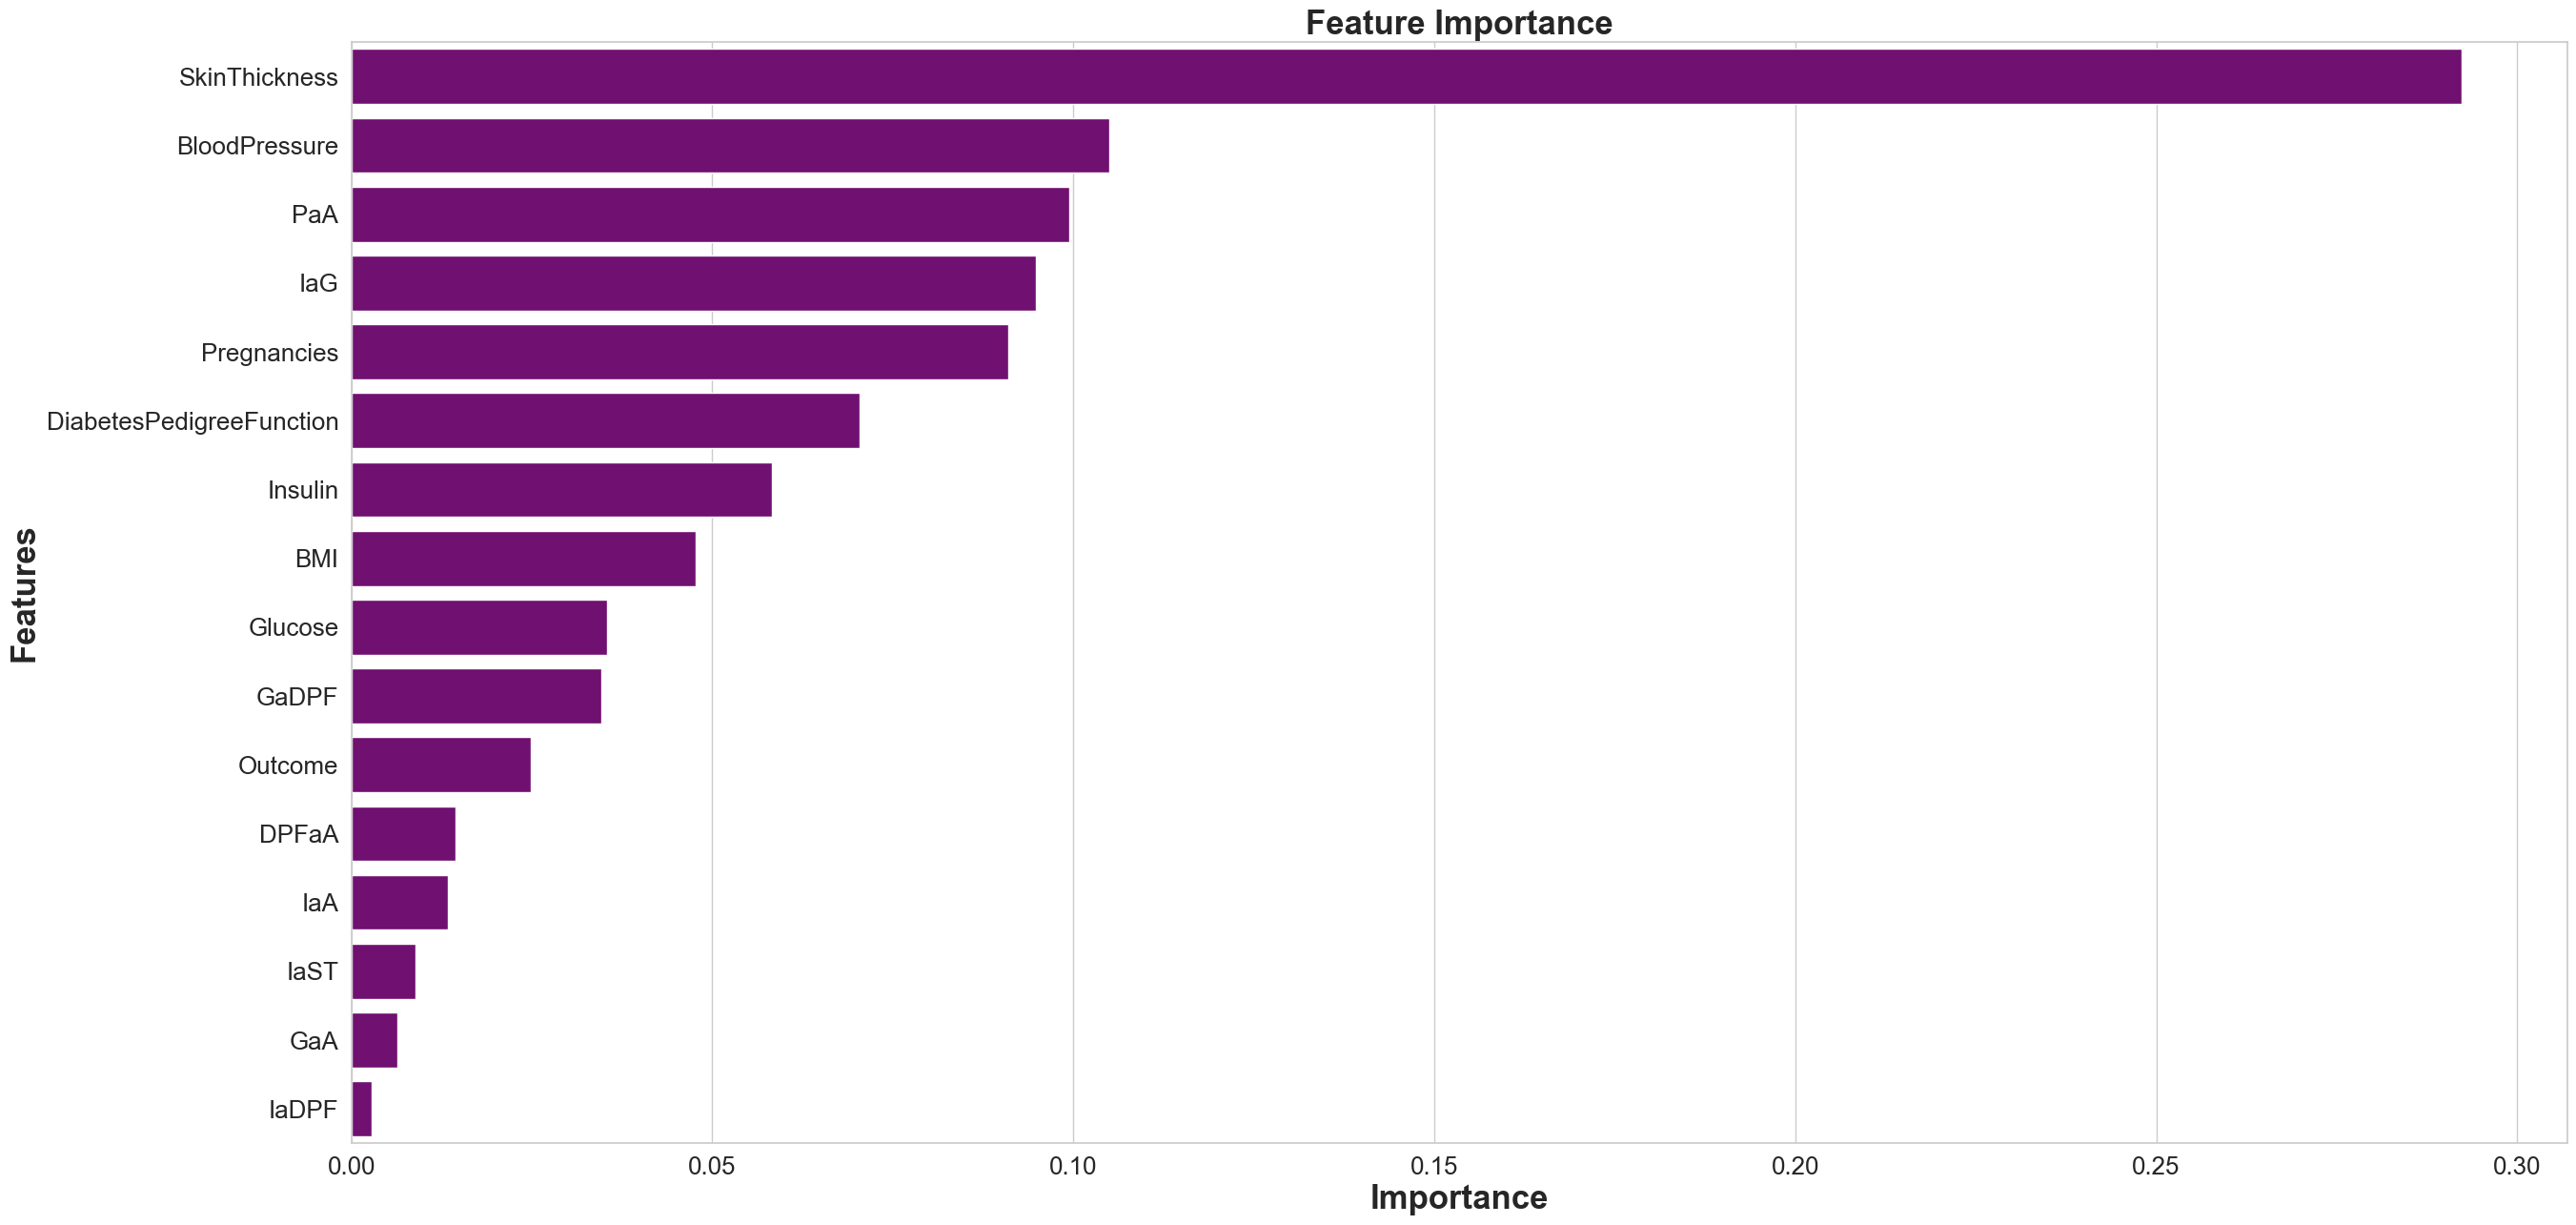

None

Features  Gini-Importance
0              SkinThickness         0.292289
1              BloodPressure         0.104982
2                        PaA         0.099482
3                        IaG         0.094891
4                Pregnancies         0.090994
5   DiabetesPedigreeFunction         0.070465
6                    Insulin         0.058263
7                        BMI         0.047707
8                    Glucose         0.035446
9                      GaDPF         0.034615
10                   Outcome         0.024848
11                     DPFaA         0.014481
12                       IaA         0.013406
13                      IaST         0.008908
14                       GaA         0.006339
15                     IaDPF         0.002886

In [347]:
feats = {}
for feature, importance in zip(df.columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='purple')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

In [162]:
train_data = lgbm.Dataset(X_train, label=y_train)
test_data = lgbm.Dataset(X_test, label=y_test, reference=train_data)

In [163]:
params = {
    'objective': 'binary',  
    'metric': 'binary_logloss',  
    'boosting_type': 'gbdt',  
}

In [351]:
model_lgbm = lgbm.train(params, train_data, valid_sets=[test_data], num_boost_round=100)

In [353]:
y_pred_lgbm = model_lgbm.predict(X_test)

In [355]:
y_pred_lgbm = [1 if i > 0.5 else 0 for i in y_pred_lgbm]

In [357]:
print(accuracy_score(y_test, y_pred_lgbm))

0.8541666666666666


In [168]:
param_grid_rfс = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [169]:
param_grid_lgb = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 10, 20],
    'boosting_type': ['gbdt', 'dart']
}

In [170]:
rfс2 = RandomForestClassifier()
grid_rf = GridSearchCV(estimator=rfс2, param_grid=param_grid_rfс, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)
print("Лучшие параметры для RandomForestClassifier:", grid_rf.best_params_)
print("Лучший результат:", grid_rf.best_score_)

Лучшие параметры для RandomForestClassifier: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Лучший результат: 0.8958170914542729


In [171]:
lgbm2 = lgbm.LGBMClassifier(verbose=-1)
grid_lgb = RandomizedSearchCV(estimator=lgbm2, param_distributions=param_grid_lgb, n_iter=75, cv=5, scoring='accuracy')
grid_lgb.fit(X_train, y_train)
print("Лучшие параметры для LightGBM:", grid_lgb.best_params_)
print("Лучший результат:", grid_lgb.best_score_)

Лучшие параметры для LightGBM: {'num_leaves': 31, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.05, 'boosting_type': 'dart'}
Лучший результат: 0.8940929535232385


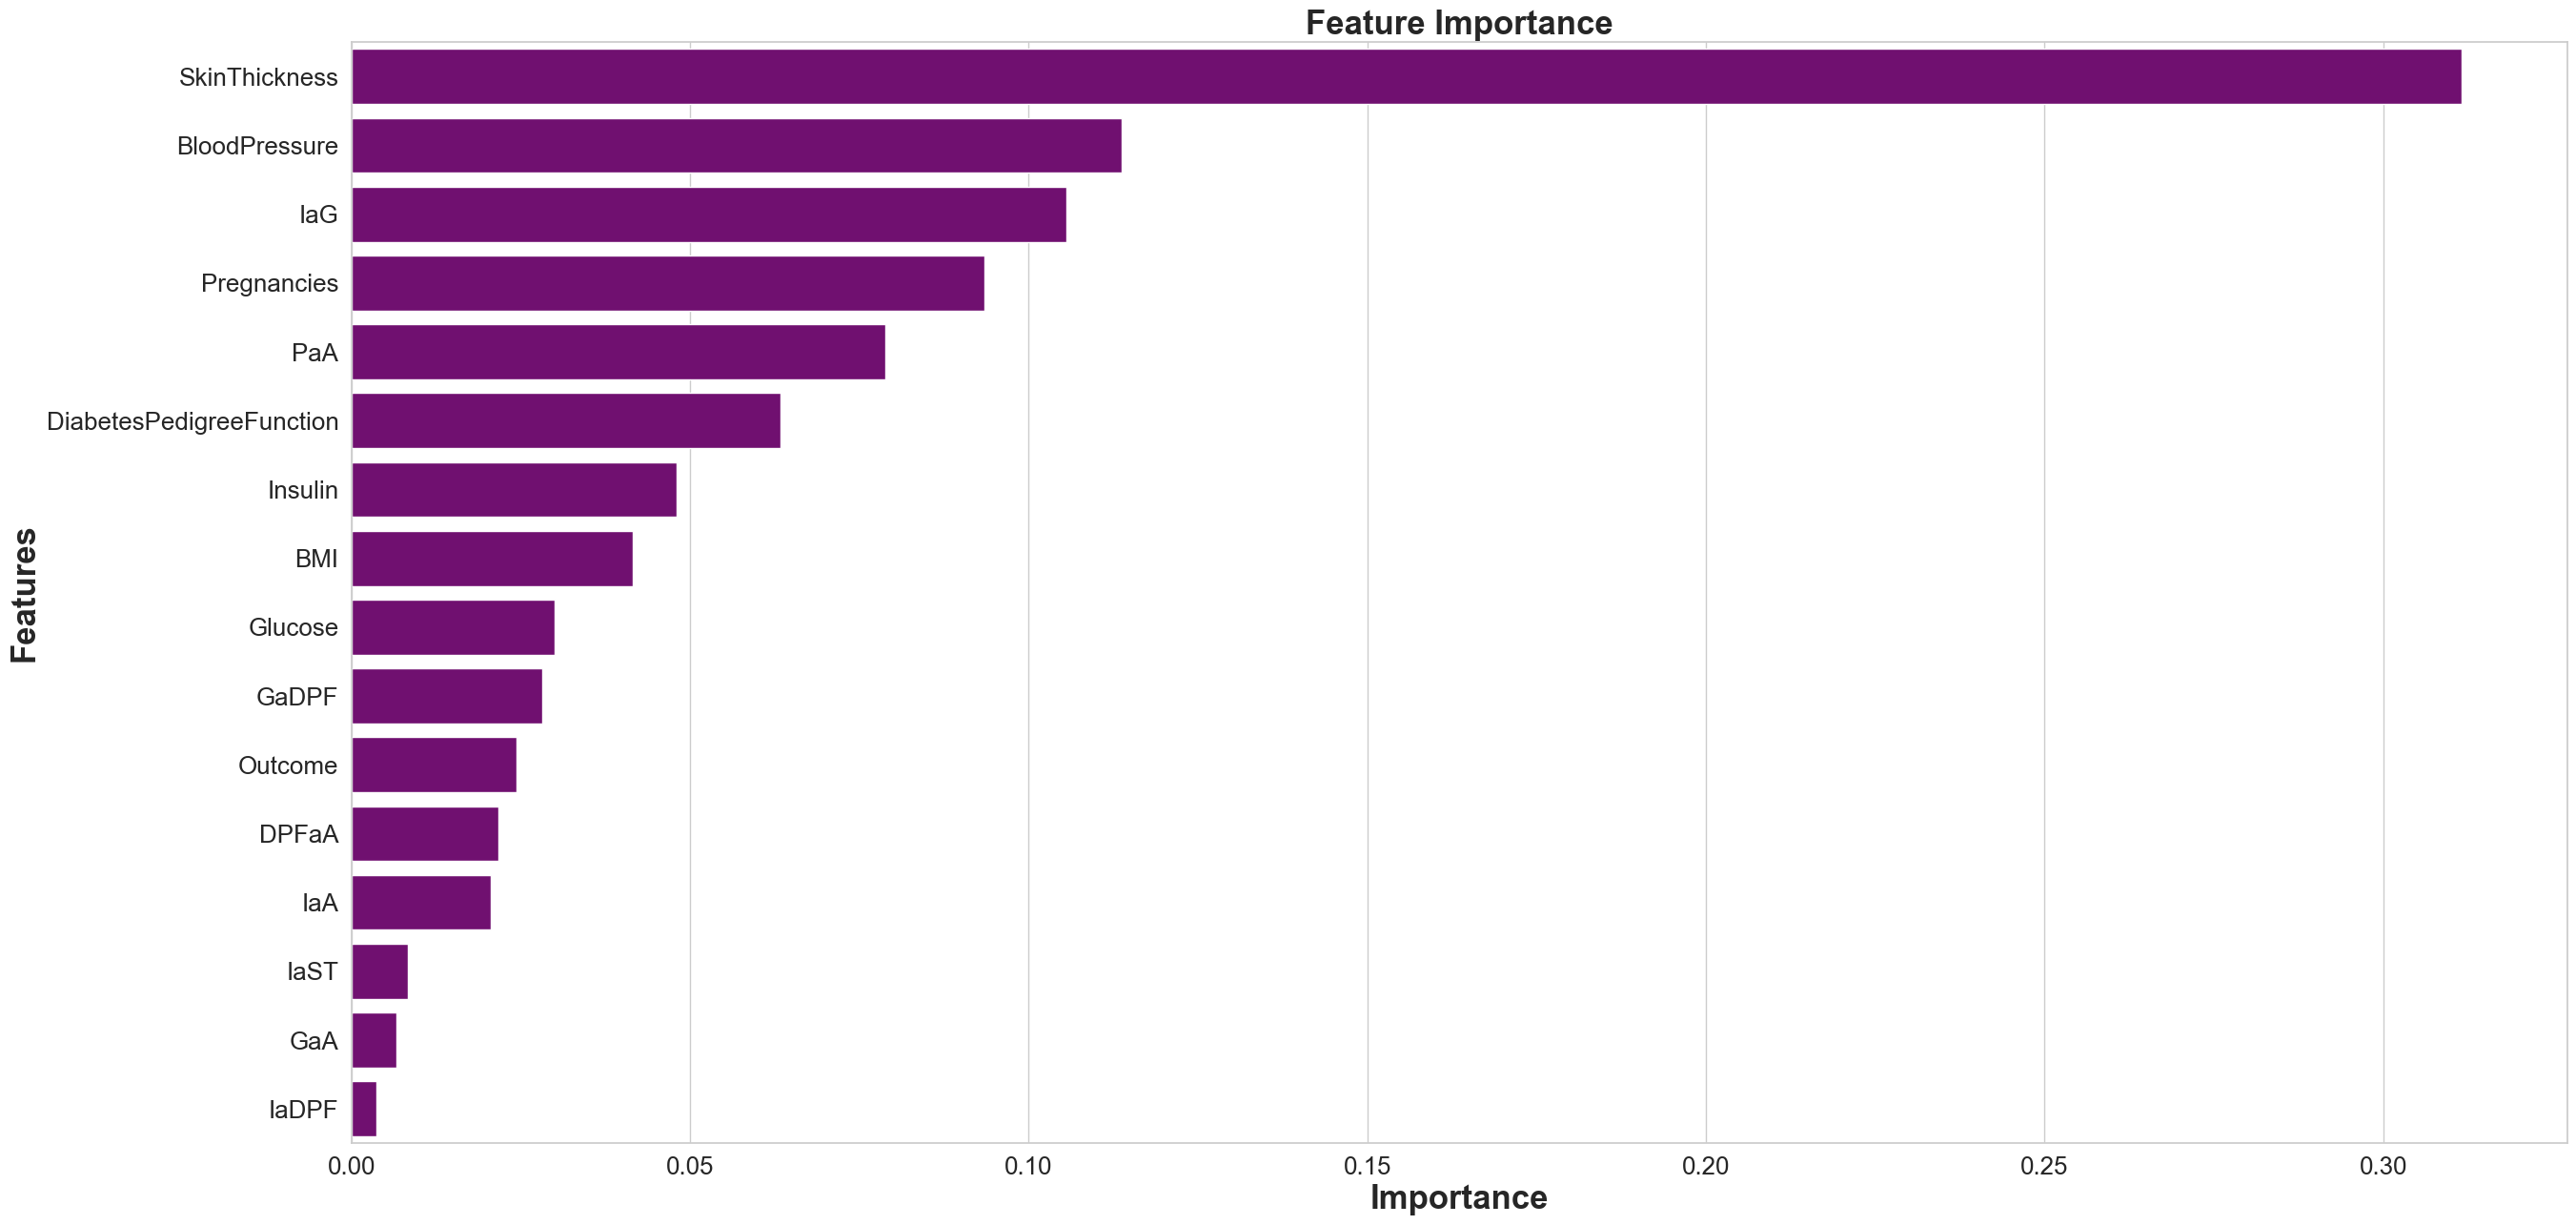

None

Features  Gini-Importance
0              SkinThickness         0.311550
1              BloodPressure         0.113709
2                        IaG         0.105518
3                Pregnancies         0.093523
4                        PaA         0.078903
5   DiabetesPedigreeFunction         0.063364
6                    Insulin         0.048084
7                        BMI         0.041578
8                    Glucose         0.030058
9                      GaDPF         0.028252
10                   Outcome         0.024342
11                     DPFaA         0.021686
12                       IaA         0.020541
13                      IaST         0.008407
14                       GaA         0.006729
15                     IaDPF         0.003755

In [359]:
feats = {}
for feature, importance in zip(df.columns, grid_rf.best_estimator_.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='purple')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances);

<h3>Заключение</h3>

В ходе работы с датасетом Pima Indians Diabetes удалось провести полный цикл анализа и построения моделей для задачи классификации наличия диабета.  

Основные достижения проекта:

- Проведен глубокий анализ исходных данных, что позволило выявить значимые взаимосвязи между признаками и целевой переменной  
- Сгенерированы 8 новых информативных признаков, что повысило качество предсказаний  
- Построены и сравнены две базовые модели — LightGBM Classifier и Random Forest Classifier без настройки параметров  
- По результатам сравнения, модель на основе Random Forest показала лучшие показатели  
- Проведен подбор гиперпараметров для RandomForestClassifier, что позволило добиться высокой финальной точности: accuracy = 0.9  

Данный результат свидетельствует о правильном выборе подходов к подготовке данных и построению моделей. Созданные дополнительные признаки и последующая оптимизация позволили извлечь максимальную ценность из предоставленного датасета, обеспечив надёжное выявление пациентов с риском развития диабета.